# Lib

In [1]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 26.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires go

In [36]:
!pip install deepbrain -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.6/677.6 kB 11.8 MB/s eta 0:00:00 0:00:01


In [1]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
	Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
	Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-06-05 08:35:25.831172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749112525.853834    1043 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749112525.860771    1043 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup

In [2]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
	DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [3]:
# config
NUM_CLIENTS = 10
NUM_ROUNDS = 15
DROPOUT = 0.3
BATCHSIZE = 32
OVERLAP = 1
LR = 0.001
epochs_round = 1

In [4]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyenxuanpk357 (nguyentuoc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Prepare Data

## Load Data

In [5]:
im = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = im.get_fdata()
data.shape, im.affine, im.header

((130, 130, 130),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 <nibabel.nifti1.Nifti1Header at 0x7be4cf259a50>)

In [6]:
def show_slice(slice_index):
	plt.imshow(data[:, :, slice_index], cmap='gray')
	plt.title(f"Axial Slice {slice_index}")
	plt.axis('off')
	plt.show()

interact(show_slice, slice_index=(0, data.shape[2] - 1));

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

In [7]:
data_dir = '/kaggle/input/mri-dataset/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [8]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

In [9]:
def load_filenames(input_path):
	input_path = Path(input_path)
	if not input_path.is_file():
		raise FileNotFoundError(f"File {input_path} không tồn tại")
	with open(input_path, 'r') as f:
		return [Path(path) for path in json.load(f)]

im_filenames = load_filenames("/kaggle/input/federated-learning/valid_filenames.json")

def extract_subject_id(path):
	for part in path.parts:
		if part.startswith("sub-BrainAge"):
			return part
	return None

valid_subject_ids = set()
for path in im_filenames:
	sid = extract_subject_id(path)
	if sid:
		valid_subject_ids.add(sid)

label_ls = label_ls[label_ls['subject_id'].isin(valid_subject_ids)]
len(label_ls)

4948

In [10]:
label_ls['subject_sex'].value_counts()

subject_sex
f    2837
m    2111
Name: count, dtype: int64

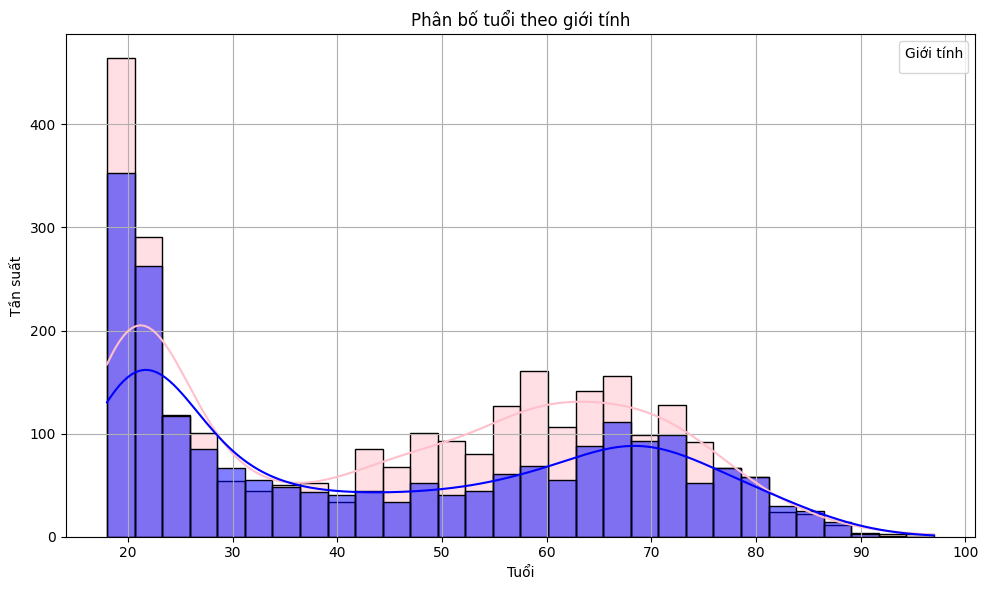

In [11]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True,
			 palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis Data

In [ ]:
import plotly.graph_objects as go

# Load MRI data
img = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = img.get_fdata()

# Normalize to [0, 1]
data = (data - np.min(data)) / (np.max(data) - np.min(data))

data = data[30:130, 30:130, 30:130]

# Apply threshold for visualization (keep only high intensity)
threshold = 0.4
x, y, z = np.where(data > threshold)
intensity = data[x, y, z]

# Create 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
	x=x, y=y, z=z,
	mode='markers',
	marker=dict(
		size=1.5,
		color=intensity,
		colorscale='Viridis',
		opacity=0.1
	)
))

fig.update_layout(
	scene=dict(
		xaxis=dict(visible=False),
		yaxis=dict(visible=False),
		zaxis=dict(visible=False),
	),
	title="3D MRI Volume",
	margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

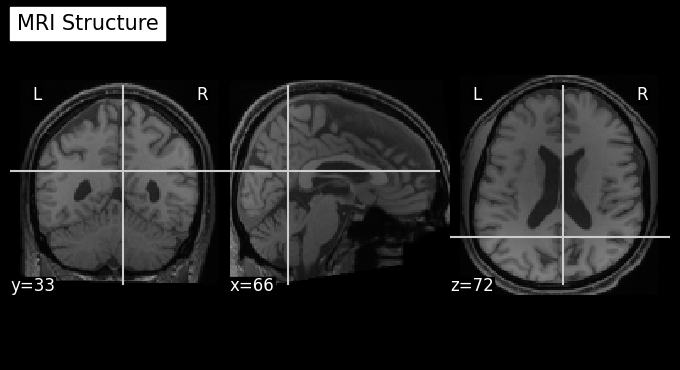

In [ ]:
from nilearn import plotting

plotting.plot_anat(
	'/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii',
	display_mode='ortho',  # hiển thị 3 chiều: axial, sagittal, coronal
	title='MRI Structure',
	annotate=True,
	draw_cross=True
)
plotting.show()


In [ ]:
from scipy.ndimage import zoom, binary_erosion
from scipy.stats import ttest_ind
from nilearn import plotting
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
import deepbrain.extractor
deepbrain.extractor.tf = tf.compat.v1
from deepbrain import Extractor

ext = Extractor()


def load_subject_image(subject_id):
	if subject_id == "sub-BrainAge005600":
		return None
	nii_path = Path(f'{data_dir}/{subject_id}/anat/{subject_id}_T1w.nii/{subject_id}_T1w.nii')
	if nii_path.exists():
		return nib.load(str(nii_path)).get_fdata()
	print(nii_path)
	return None

def extract_brain(image):
	prob = ext.run(image)
	brain_mask = prob > 0.5
	eroded_mask = binary_erosion(brain_mask, iterations=2)
	return image * eroded_mask

def resize_image(img, target_shape=(128, 128, 128)):
	zoom_factors = [t / s for t, s in zip(target_shape, img.shape)]
	return zoom(img, zoom=zoom_factors, order=1)

def process_group(df, target_shape):
	imgs = []
	for _, row in tqdm(df.iterrows(), total=len(df)):
		img = load_subject_image(row['subject_id'])
		if img is None:
			continue
		brain_img = extract_brain(img)
		resized_img = resize_image(brain_img, target_shape)
		imgs.append(resized_img)
	return np.array(imgs)

I0000 00:00:1748935256.823716    4065 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13902 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748935256.824048    4065 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def show_csf_segmentation(image, csf_mask, slice_idx=None):
	if slice_idx is None:
		slice_idx = image.shape[2] // 2  # chọn lát giữa

	img_slice = image[:, :, slice_idx]
	mask_slice = csf_mask[:, :, slice_idx]

	plt.figure(figsize=(12, 5))

	plt.subplot(1, 3, 1)
	plt.imshow(img_slice.T, cmap='gray', origin='lower')
	plt.title('Ảnh MRI gốc')
	plt.axis('off')

	plt.subplot(1, 3, 2)
	plt.imshow(mask_slice.T, cmap='Reds', origin='lower')
	plt.title('CSF Mask (threshold-based)')
	plt.axis('off')

	plt.subplot(1, 3, 3)
	plt.imshow(img_slice.T, cmap='gray', origin='lower')
	plt.imshow(mask_slice.T, cmap='Reds', alpha=0.4, origin='lower')
	plt.title('Overlay')
	plt.axis('off')

	plt.tight_layout()
	plt.show()

I0000 00:00:1748935264.653984    4065 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13902 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748935264.654259    4065 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1748935265.020344    4065 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
I0000 00:00:1748935265.277693    5802 cuda_dnn.cc:529] Loaded cuDNN version 90300


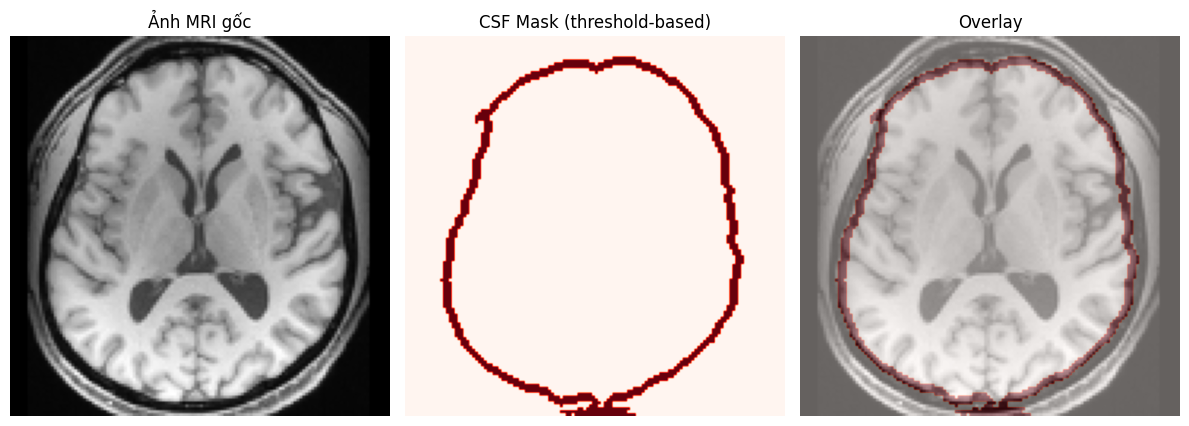

In [ ]:
from scipy.ndimage import binary_erosion
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Monkey patch để deepbrain dùng TF1
import deepbrain.extractor
deepbrain.extractor.tf = tf.compat.v1

from deepbrain import Extractor
ext = Extractor()


def extract_csf_mask(image):
	prob = ext.run(image)
	brain_mask = prob > 0.5
	eroded = binary_erosion(brain_mask, iterations=3)
	csf_mask = brain_mask ^ eroded
	return csf_mask

test_img = load_subject_image('sub-BrainAge000000')

csf_mask = extract_csf_mask(test_img)

show_csf_segmentation(test_img, csf_mask)

In [ ]:
def show_mridata_distribution(low_age, high_age, num_samples=50):
	male = label_ls[(label_ls['subject_sex'].str.lower().str.strip() == 'm') & 
				(label_ls['subject_age'].between(low_age, high_age))].head(num_samples)
	female = label_ls[(label_ls['subject_sex'].str.lower().str.strip() == 'f') & 
				  (label_ls['subject_age'].between(low_age, high_age))].head(num_samples)
	target_shape = (128, 128, 128)
	male_imgs = process_group(male, target_shape)
	female_imgs = process_group(female, target_shape)
	print(f"Loaded {len(male_imgs)} male and {len(female_imgs)} female images")
	
	t_stat, _ = ttest_ind(female_imgs, male_imgs, axis=0, equal_var=False)
	sample_affine = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii').affine
	t_map_img = nib.Nifti1Image(t_stat, affine=sample_affine)
	
	plotting.plot_stat_map(
		t_map_img,
		title=f"T-statistic map (Female - Male) for Age Range {low_age}-{high_age} years",
		display_mode="z",
		cut_coords=10,
		cmap="cold_hot",
		threshold=1
	)
	plotting.show()

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Loaded 100 male and 100 female images


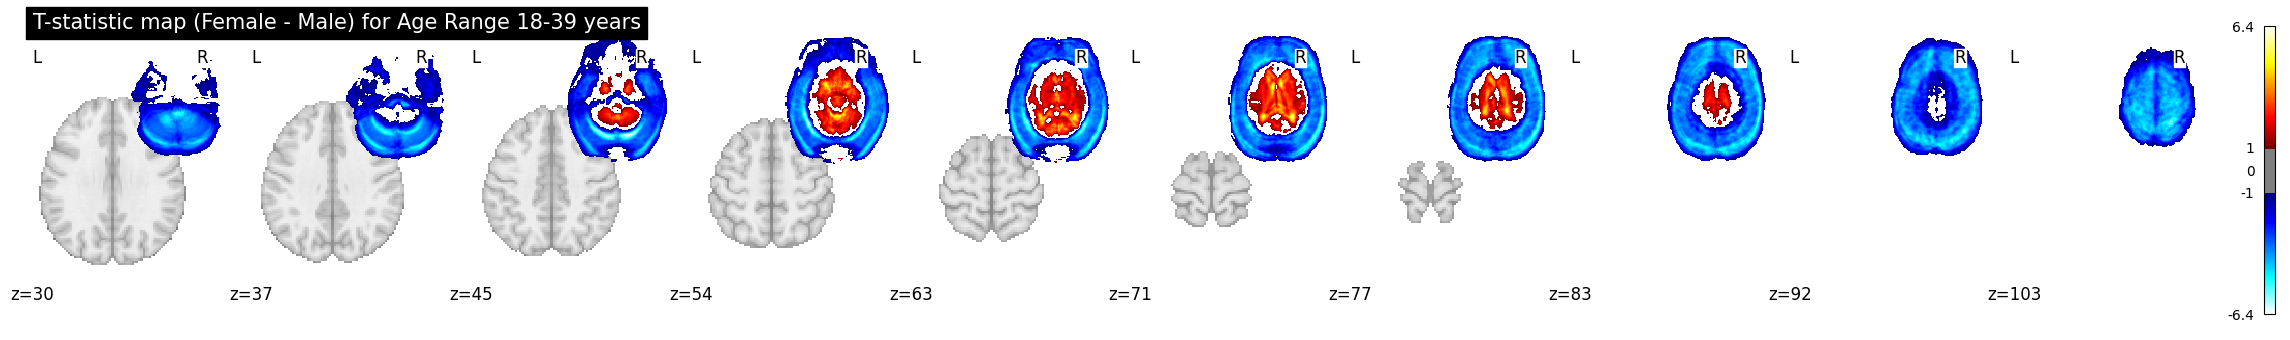

In [48]:
show_mridata_distribution(18, 39, num_samples=100)

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Loaded 100 male and 100 female images


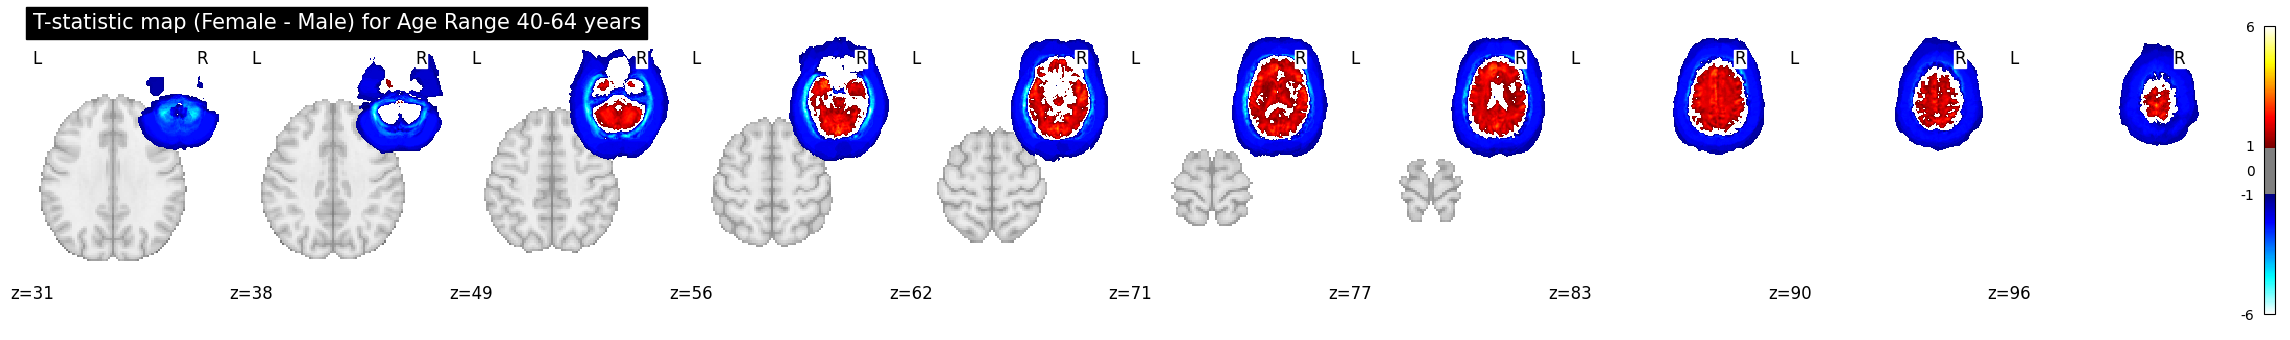

In [49]:
show_mridata_distribution(40, 64, num_samples=100)

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Loaded 100 male and 100 female images


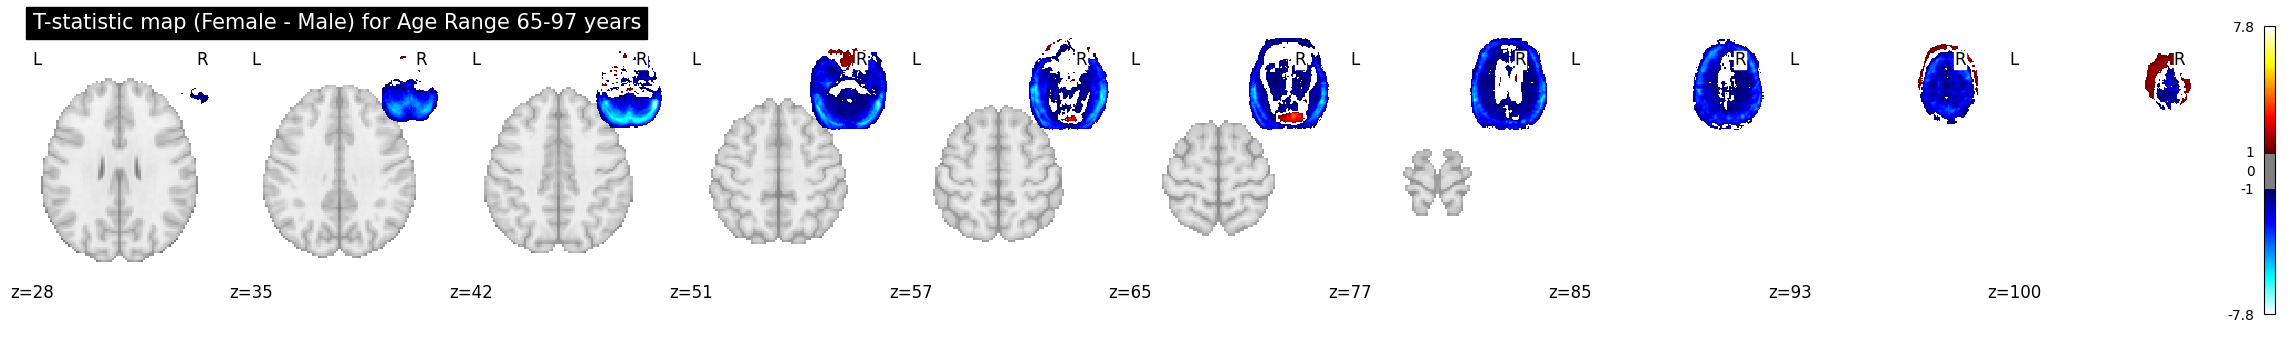

In [50]:
show_mridata_distribution(65, 97, num_samples=100)

## Dataset

### Data

In [12]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata.head()

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0


In [13]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

4948

In [22]:
class MRIDataset(Dataset):
	def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
		self.im_dir = Path(im_dir)
		self.label_ls = label_ls
		self.transform = transform

		if im_filenames is not None:
			self.im_filenames = im_filenames
		else:
			self.im_filenames = self._gather_valid_paths()

	def _gather_valid_paths(self):
		paths = self.im_dir.glob("*/*/*/*.nii")
		valid_paths = []
		fail_paths = {
			self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
		}

		for path in paths:
			if not path.is_file():
				continue
				
			if path in fail_paths:
				continue
				
			subject_id = self._extract_subject_id(path)
			if subject_id not in self.label_ls:
				continue
			try:
				# nib.load(path).get_fdata()
				nib.load(path)
				valid_paths.append(path)
			except Exception:
				continue
		return valid_paths

	def _extract_subject_id(self, path):
		for part in Path(path).parts:
			if part.startswith("sub-BrainAge"):
				return part  # ví dụ: "sub-BrainAge000000"
		return None

	def _normalize(self, im):
		im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
		return im.astype(np.float32)

	def _get_label(self, subject_id):
		sex = self.label_ls.get(subject_id, {}).get("subject_sex")
		if sex == 'm':
			return 0
		elif sex == 'f':
			return 1
		else:
			raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
			
	def _get_age(self, subject_id):
		return self.label_ls.get(subject_id, {}).get("subject_age")
	
	def __len__(self):
		return len(self.im_filenames)

	# 3D volume extraction
	# def __getitem__(self, idx):
	# 	im_path = self.im_filenames[idx]
	# 	subject_id = self._extract_subject_id(im_path)

	# 	im = nib.load(im_path).get_fdata()
	# 	im = self._normalize(im)

	# 	label = self._get_label(subject_id)
	# 	image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

	# 	if self.transform:
	# 		image = self.transform(image)

	# 	return image, torch.tensor(label, dtype=torch.long)
	
	# 2D slice extraction
	def __getitem__(self, idx):
		im_path = self.im_filenames[idx]
		subject_id = self._extract_subject_id(im_path)

		im = nib.load(im_path).get_fdata()
		im = self._normalize(im)

		mid_slice = im.shape[2] // 2
		im_slice = im[:, :, mid_slice]
		
		image_2d = np.stack([im_slice]*3, axis=0)
		image_tensor = torch.from_numpy(image_2d).float()

		if self.transform:
			image_tensor = self.transform(image_tensor)

		label = self._get_label(subject_id)
		return image_tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames=im_filenames)
len(dataset)

In [ ]:
all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
	all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
	im_dir=dataset.im_dir,
	label_ls=dataset.label_ls,
	transform=dataset.transform,
	im_filenames=train_filenames
)

testset = MRIDataset(
	im_dir=dataset.im_dir,
	label_ls=dataset.label_ls,
	transform=dataset.transform,
	im_filenames=test_filenames
)


In [ ]:
# def save_filenames(im_filenames, output_path):
#     output_path = Path(output_path)
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     with open(output_path, 'w') as f:
#         json.dump([str(path) for path in im_filenames], f)
#     print(output_path)

# save_filenames(dataset.im_filenames, "valid_filenames.json")

### IID Data

In [15]:
def extract_subject_id_from_path(path: Path):
    for part in path.parts:
        if part.startswith("sub-BrainAge"):
            return part
    return None

def build_metadata_from_filenames(im_filenames, label_ls):
    records = []
    for idx, path in enumerate(im_filenames):
        subject_id = extract_subject_id_from_path(path)
        if subject_id is None or subject_id not in label_ls:
            continue

        info = label_ls[subject_id]
        age = info.get("subject_age")
        sex = info.get("subject_sex")
        if age is None or sex not in {"m", "f"}:
            continue

        records.append({
            "subject_id": subject_id,
            "subject_age": age,
            "subject_sex": sex,
            "path": path,
            "original_index": idx
        })
    df = pd.DataFrame(records)
    df = df.set_index("original_index")
    return df

def prepare_data_from_filenames(im_filenames, label_ls):
    df = build_metadata_from_filenames(im_filenames, label_ls)
    if len(df) == 0:
        raise ValueError("No valid data found after building metadata.")
    df["age_group"] = pd.qcut(df["subject_age"], q=min(5, len(df)), labels=False)
    df["key"] = df.apply(lambda row: f"{row['age_group']}_{row['subject_sex']}", axis=1)
    return df

def sampling_data(data, size, random_state):
    group_key = 'key'
    groups = data.groupby(group_key, group_keys=False)

    per_group = int(size / len(data[group_key].unique()))

    samples = groups.apply(
        lambda x: x.sample(
            n=min(per_group, len(x)),
            replace=len(x) < per_group,
            random_state=random_state
        ), include_groups=False)

    if len(samples) < size:
        additional = data.drop(samples.index).sample(
            n=min(size - len(samples), len(data) - len(samples)),
            replace=True,
            random_state=random_state
        )
        samples = pd.concat([samples, additional])

    return samples

def distributed_filenames_to_clients(data, num_clients, overlap_ratio=0.0):
    df = prepare_data_from_filenames(data.im_filenames, data.label_ls)
    n_samples = len(df)
    samples_per_client = int(n_samples / (num_clients * (1 - overlap_ratio) + overlap_ratio))

    selected_samples = {}
    client_indices = []

    for client_idx in range(num_clients):
        if client_idx == 0:
            client_data = df.sample(n=samples_per_client, random_state=42 + client_idx)
        else:
            overlap_size = int(samples_per_client * overlap_ratio)
            non_overlap_size = samples_per_client - overlap_size

            all_previous_samples = pd.DataFrame()
            for prev_client_idx in range(client_idx):
                all_previous_samples = pd.concat([all_previous_samples, selected_samples[prev_client_idx]])

            if len(all_previous_samples) > 0:
                overlap_samples = sampling_data(all_previous_samples, overlap_size, client_idx * 100 + 42)
            else:
                overlap_samples = pd.DataFrame(columns=df.columns)

            remaining_indices = df.index.difference(all_previous_samples.index)
            if len(remaining_indices) > 0:
                remaining_df = df.loc[remaining_indices]
                non_overlap_samples = sampling_data(remaining_df, non_overlap_size, client_idx * 100 + 42)
            else:
                non_overlap_samples = df.sample(n=non_overlap_size, replace=True, random_state=42 + client_idx * 300)

            client_data = pd.concat([overlap_samples, non_overlap_samples])

        selected_samples[client_idx] = client_data
        client_indices.append(client_data.index.to_list())

    return client_indices


In [39]:
client_indices = distributed_filenames_to_clients(trainset, num_clients=10, overlap_ratio=0.0)

def load_client_datasets(partition_id: int, num_partitions: int, dataset, client_index):
	sampled_indices = client_index[partition_id]
	np.random.shuffle(sampled_indices)
	train_size = int(0.8 * len(sampled_indices))
	train_indices = sampled_indices[:train_size]
	val_indices = sampled_indices[train_size:]

	train_subset = Subset(dataset, train_indices)
	val_subset = Subset(dataset, val_indices)
	return train_subset, val_subset

In [ ]:
def load_server_test_datasets(data: MRIDataset):
	testloader = DataLoader(data, batch_size=BATCHSIZE, shuffle=False)
	return testloader

### Non-IID Data

In [ ]:
def create_global_bin_pool(data: MRIDataset) -> dict:
	subject_metadata = data.label_ls
	subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

	age_array = np.array([
		subject_metadata.get(sid, {}).get("subject_age", np.nan)
		for sid in subject_ids
	], dtype=np.float32)

	valid_mask = ~np.isnan(age_array)
	valid_indices = np.arange(len(data.im_filenames))[valid_mask]
	age_array = age_array[valid_mask]

	bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	age_bins = np.digitize(age_array, bins, right=False)

	global_bin_pool = {}
	for bin_id in np.unique(age_bins):
		bin_indices = valid_indices[age_bins == bin_id]
		global_bin_pool[bin_id] = set(bin_indices.tolist())

	return global_bin_pool


def get_sample_data(
	data: MRIDataset,
	overlap: float,
	partition_id: int,
	num_partitions: int,
	global_bin_pool: dict,
	num_samples: int = None,
) -> list:
	subject_metadata = data.label_ls
	subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

	age_array = np.array(
		[subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
		dtype=np.float32
	)

	valid_mask = ~np.isnan(age_array)
	valid_indices = np.arange(len(data.im_filenames))[valid_mask]
	age_array = age_array[valid_mask]

	bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	# age_bins = np.digitize(age_array, bins, right=False)
	total_samples = len(valid_indices)
	client_sample_count = total_samples // num_partitions

	rng = np.random.default_rng(seed=partition_id + 42)
	sampled_indices = set()
	used_bins = set()

	all_bins = list(global_bin_pool.keys())
	rng.shuffle(all_bins)
	target_num_bins = max(1, int(overlap * len(all_bins)))

	# Vòng lặp đến khi đủ sample
	while len(sampled_indices) < client_sample_count:
		# Chọn bin chưa dùng
		candidate_bins = [b for b in all_bins if b not in used_bins]
		if not candidate_bins:
			break  # Không còn bin nào để lấy

		selected_bins = candidate_bins[:target_num_bins]
		used_bins.update(selected_bins)

		# Lấy toàn bộ samples từ các bin đã chọn
		combined_indices = []
		for bin_id in selected_bins:
			available = global_bin_pool[bin_id]
			combined_indices.extend(list(available))

		rng.shuffle(combined_indices)

		# Chọn mẫu đến khi đủ
		needed = client_sample_count - len(sampled_indices)
		to_take = combined_indices[:needed]
		sampled_indices.update(to_take)

		# Xoá mẫu đã chọn khỏi global_bin_pool
		for idx in to_take:
			for bin_id in selected_bins:
				global_bin_pool[bin_id].discard(idx)

	if num_samples and num_samples > client_sample_count:
		remaining_needed = num_samples - client_sample_count
		remaining_pool = list(set(valid_indices) - sampled_indices)
		rng.shuffle(remaining_pool)
		extra = remaining_pool[:remaining_needed]
		sampled_indices.update(extra)

	return list(sampled_indices)

In [ ]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
	data = dataset
	sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
									  global_bin_pool=global_bin_pool, num_samples=num_samples)

	np.random.shuffle(sampled_indices)
	train_size = int(0.8 * len(sampled_indices))
	train_indices = sampled_indices[:train_size]
	val_indices = sampled_indices[train_size:]

	train_subset = Subset(data, train_indices)
	val_subset = Subset(data, val_indices)
	return train_subset, val_subset

In [16]:
def load_server_test_datasets(data: MRIDataset):
	testloader = DataLoader(data, batch_size=BATCHSIZE, shuffle=False)
	return testloader

In [21]:
global_bin_pool = create_global_bin_pool(trainset)

### Show Client Data

In [ ]:
global_bin_pool = create_global_bin_pool(trainset)

In [59]:
train_subset, _ = load_client_datasets(partition_id=1, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
client_1, _ = load_client_datasets(partition_id=1, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
client_2, _ = load_client_datasets(partition_id=1, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
print(len(train_subset))

316


In [ ]:
dataloader = DataLoader(train_subset, batch_size=2)
images, labels = dataloader
print(f"Batch size: {images.shape}, Labels: {labels}")
images = images.numpy()
slice_idx = images.shape[3] // 2
slices = images[:, :, :, slice_idx]

class_names = ["Male", "Female"]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
	if i < len(slices):
		ax.imshow(slices[i], cmap='gray')
		ax.set_title(class_names[labels.item()])
		ax.axis("off")
	else:
		ax.axis("off")

plt.tight_layout()
plt.show()

In [37]:
def plot_age_distribution(subset, id: int = 0):
	dataset = subset.dataset
	indices = subset.indices

	data = []
	for i in indices:
		subject_id = dataset._extract_subject_id(dataset.im_filenames[i])
		metadata = dataset.label_ls.get(subject_id, {})
		age = metadata.get("subject_age")
		sex = metadata.get("subject_sex")
		if age is not None and not pd.isna(age) and sex in ['m', 'f']:
			data.append({"age": age, "sex": sex })

	if not data:
		print("No valid age/sex data found.")
		return

	df = pd.DataFrame(data)

	plt.figure(figsize=(8, 5))
	sns.histplot(data=df, x="age", hue="sex", bins=30, kde=True, palette={"m": "blue", "f": "pink"}, edgecolor="black")
	plt.title(f"Age Distribution by Sex for Client ID {id}")
	plt.xlabel("Age")
	plt.ylabel("Count")
	plt.grid(True)
	plt.tight_layout()
	plt.show()

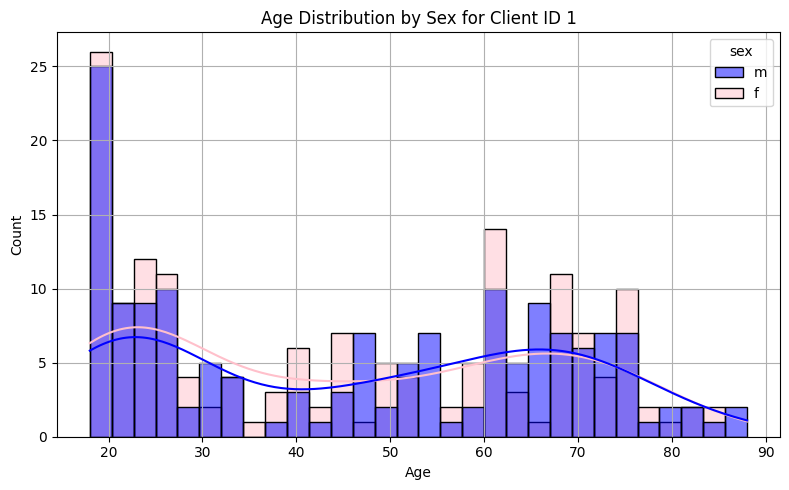

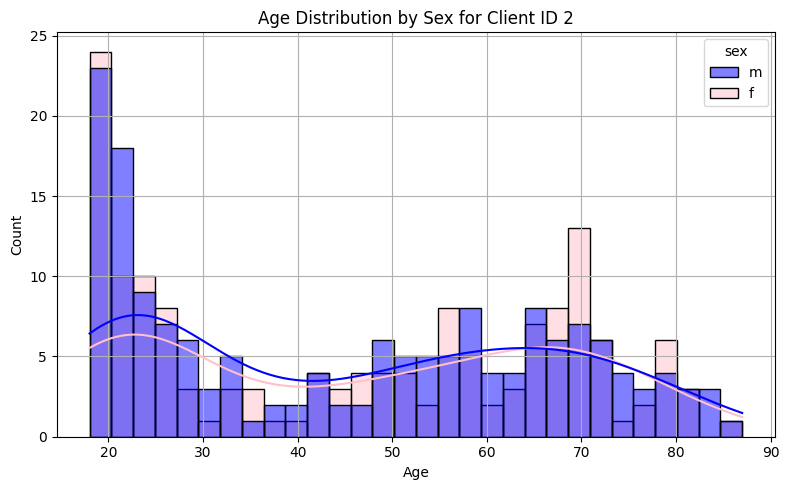

In [41]:
client_1, _ = load_client_datasets(partition_id=1, num_partitions=10, dataset=trainset, client_index=client_indices)
client_2, _ = load_client_datasets(partition_id=2, num_partitions=10, dataset=trainset, client_index=client_indices)

plot_age_distribution(client_1, id=1)
plot_age_distribution(client_2, id=2)

In [ ]:
def analyze_sex_difference(subset, id, num_sample=30, threshold=1):
	dataset = subset.dataset
	indices = subset.indices

	# Lấy ra subject_id, tuổi và giới tính
	metadata = []
	for i in indices:
		im_path = dataset.im_filenames[i]
		sid = dataset._extract_subject_id(im_path)
		label = dataset.label_ls.get(sid, {})
		age = label.get("subject_age")
		sex = label.get("subject_sex")
		if sex in ['m', 'f'] and age is not None and not pd.isna(age):
			metadata.append({"idx": i, "subject_id": sid, "age": age, "sex": sex.lower().strip()})

	df = pd.DataFrame(metadata)

	# Chọn các mẫu không lọc tuổi
	male_ids = df[df["sex"] == 'm'].sample(n=num_sample, random_state=42)
	female_ids = df[df["sex"] == 'f'].sample(n=num_sample, random_state=42)

	print(f"Loading images: {len(male_ids)} male, {len(female_ids)} female")

	# Sử dụng process_group 
	target_shape=(128, 128, 128)
	male_imgs = process_group(male_ids, target_shape)
	female_imgs = process_group(female_ids, target_shape)

	# Thống kê voxel-wise
	t_stat, _ = ttest_ind(female_imgs, male_imgs, axis=0, equal_var=False)

	# Load affine từ một mẫu bất kỳ
	sample_path = dataset.im_filenames[indices[0]]
	sample_affine = nib.load(sample_path).affine
	t_map_img = nib.Nifti1Image(t_stat, affine=sample_affine)

	# Hiển thị
	plot_age_distribution(subset, id)
	print("Displaying T-statistic map (Female - Male)...")
	plotting.plot_stat_map(
		t_map_img,
		title=f"T-statistic map (Female - Male) Client ID {id}",
		display_mode="z",
		cut_coords=10,
		cmap="cold_hot",
		threshold=threshold
	)
	plotting.show()

Loading images: 100 male, 100 female


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


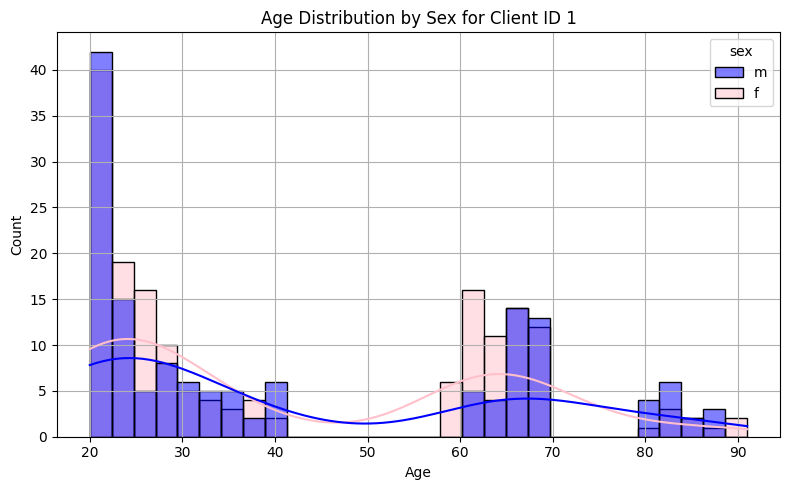

Displaying T-statistic map (Female - Male)...


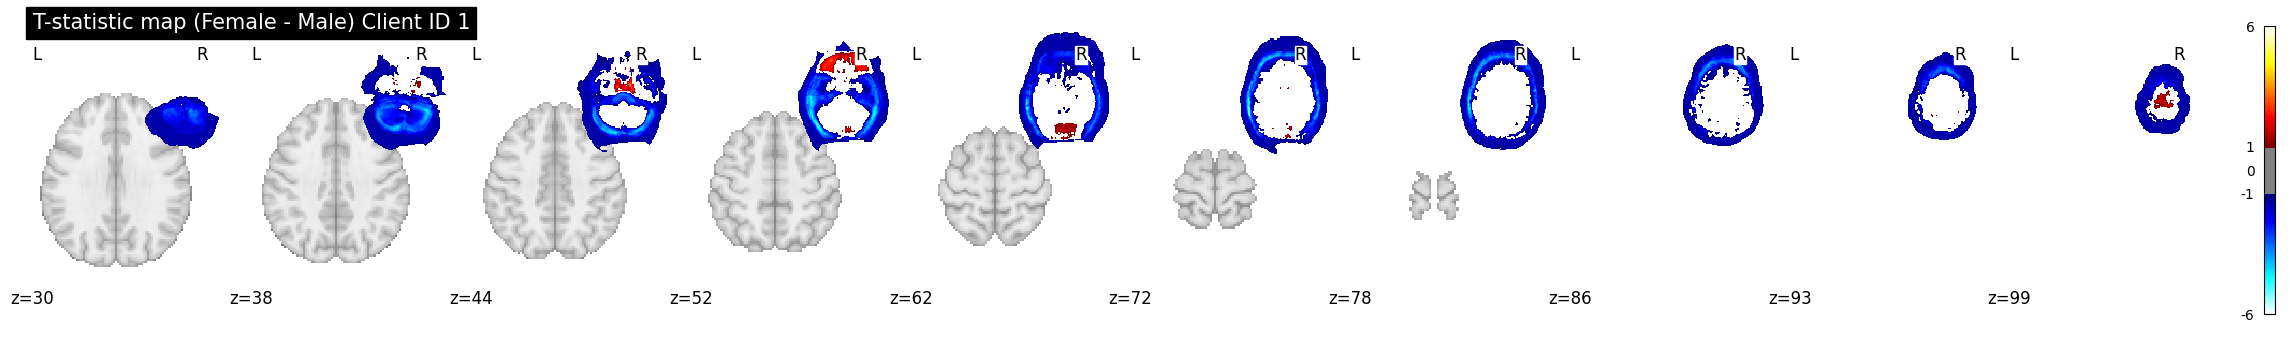

In [69]:
analyze_sex_difference(client_1, num_sample=100, id=1)

Loading images: 100 male, 100 female


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


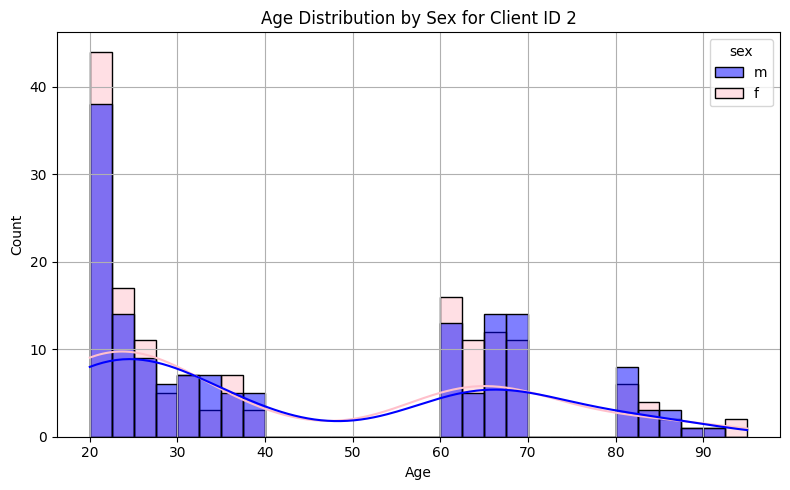

Displaying T-statistic map (Female - Male)...


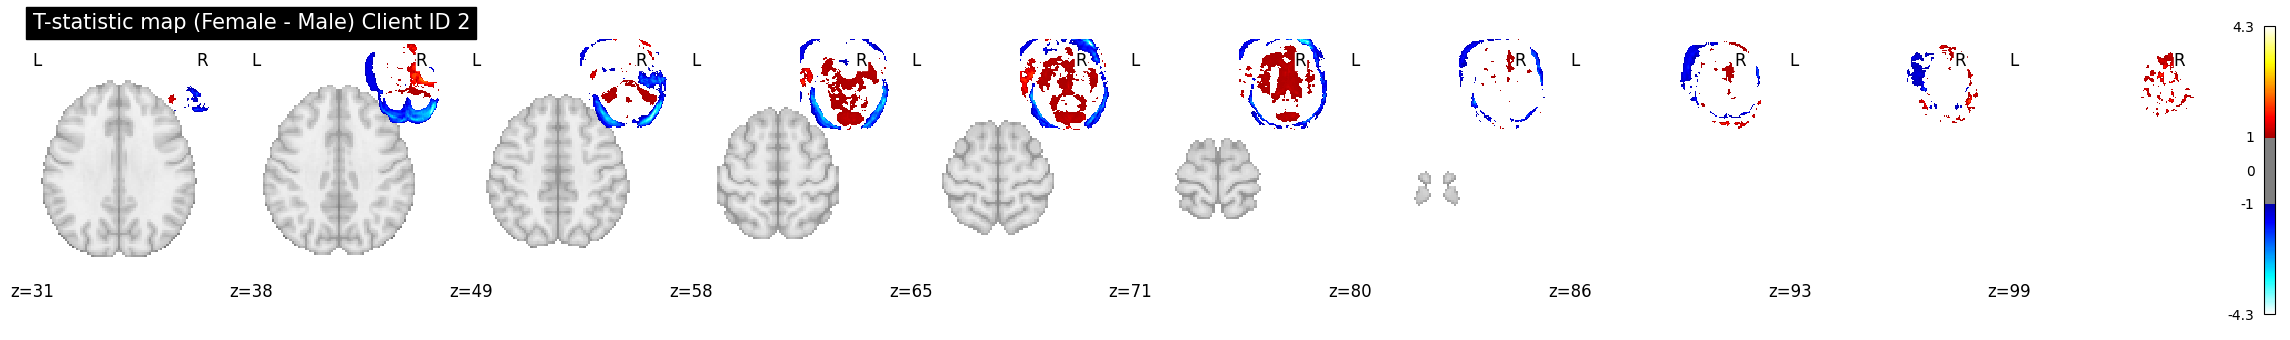

In [65]:
analyze_sex_difference(client_2, num_sample=100, id=2)

In [ ]:
def visualize_age_client_distribution(dataset, num_partitions=10, num_samples=None, overlap=0.6, global_bin_pool=None):
	# dữ liệu gốc
	subject_metadata = dataset.label_ls
	subject_ids = [dataset._extract_subject_id(path) for path in dataset.im_filenames]

	age_array = np.array(
		[subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
		dtype=np.float32
	)

	valid_mask = ~np.isnan(age_array)
	age_array = age_array[valid_mask]

	# Thêm cột phân biệt nguồn gốc
	original_df = pd.DataFrame({
		"age": age_array,
		"partition": "Original"
	})
	
	all_dfs = []

	for i in range(num_partitions):
		subset, _ = load_client_datasets(
			partition_id=i, 
			num_partitions=num_partitions, 
			dataset=dataset, 
			num_samples=num_samples,
			overlap=overlap,
			global_bin_pool=global_bin_pool
		)
		subset_data = []

		for idx in subset.indices:
			subject_id = subset.dataset._extract_subject_id(subset.dataset.im_filenames[idx])
			metadata = subset.dataset.label_ls.get(subject_id, {})
			age = metadata.get("subject_age")

			if age is not None and not pd.isna(age):
				subset_data.append({"age": age, "partition": f"Client {i}"})

		if subset_data:
			df = pd.DataFrame(subset_data)
			all_dfs.append(df)

	combined_df = pd.concat(all_dfs, ignore_index=True)
	compare_df = pd.concat([original_df, combined_df], ignore_index=True)

	print(f'Số mẫu dữ liệu:{len(combined_df)}')

	original_total = len(original_df)

	plt.figure(figsize=(12, 7))
	
	for partition in compare_df["partition"].unique():
		sub_df = compare_df[compare_df["partition"] == partition]
		weights = np.ones(len(sub_df)) / original_total
		sns.kdeplot(
			x=sub_df["age"],
			label=partition,
			linewidth=2.5 if partition == "Original" else 1.2,
			fill=(partition == "Original"),
			alpha=0.3 if partition == "Original" else 0.4,
			common_norm=False,
		)

	plt.title(f"Age Distributions Across Client (Overlap = {overlap})")
	plt.xlabel("Age")
	plt.ylabel("Density")
	plt.legend(title="Data Source")
	plt.grid(True)
	plt.tight_layout()
	plt.show()

In [ ]:
def visualize_labels_client_distribution(dataset, num_partitions=10, num_samples=None, overlap=0.6, global_bin_pool=None):
	client_gender_count = {}  # Dùng để đếm số lượng nam/nữ trong từng client

	for i in range(num_partitions):
		subset, _ = load_client_datasets(
			partition_id=i,
			num_partitions=num_partitions,
			dataset=dataset,
			num_samples=num_samples,
			overlap=overlap,
			global_bin_pool=global_bin_pool
		)

		male_count = 0
		female_count = 0

		for idx in subset.indices:
			subject_id = subset.dataset._extract_subject_id(subset.dataset.im_filenames[idx])
			metadata = subset.dataset.label_ls.get(subject_id, {})
			sex = metadata.get("subject_sex")

			if sex == 'm':
				male_count += 1
			elif sex == 'f':
				female_count += 1

		client_gender_count[f"Client {i}"] = {"Male": male_count, "Female": female_count}

	# Chuẩn bị dữ liệu để vẽ biểu đồ
	clients = list(client_gender_count.keys())
	male_counts = [client_gender_count[client]["Male"] for client in clients]
	female_counts = [client_gender_count[client]["Female"] for client in clients]

	x = range(len(clients))
	bar_width = 0.35

	# Vẽ biểu đồ
	fig, ax = plt.subplots(figsize=(12, 7))
	ax.bar(x, male_counts, width=bar_width, label="Nam", color='blue')
	ax.bar([p + bar_width for p in x], female_counts, width=bar_width, label="Nữ", color='pink')

	ax.set_xlabel('Client')
	ax.set_ylabel('Number')
	ax.set_title(f'Gender Label Distribution per Client (Overlap = {overlap})')
	ax.set_xticks([p + bar_width / 2 for p in x])
	ax.set_xticklabels(clients)
	ax.legend()

	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.show()

In [ ]:
def show_interact(overlap):
	global_bin_pool = create_global_bin_pool(trainset)
	visualize_age_client_distribution(trainset, num_partitions=10, overlap=overlap, global_bin_pool=global_bin_pool)
	global_bin_pool = create_global_bin_pool(trainset)
	visualize_labels_client_distribution(trainset, num_partitions=10, overlap=overlap, global_bin_pool=global_bin_pool)

interact(show_interact, overlap=(0.0, 1.0, 0.05));

interactive(children=(FloatSlider(value=0.5, description='overlap', max=1.0, step=0.05), Output()), _dom_class…

# Model

## 3D

In [22]:
class _DenseLayer(nn.Sequential):
	def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
		super().__init__()
		self.add_module('norm1', nn.BatchNorm3d(num_input_features))
		self.add_module('relu1', nn.ReLU(inplace=True))
		self.add_module(
			'conv1',
			nn.Conv3d(num_input_features,
					  bn_size * growth_rate,
					  kernel_size=1,
					  stride=1,
					  bias=False))
		self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
		self.add_module('relu2', nn.ReLU(inplace=True))
		self.add_module(
			'conv2',
			nn.Conv3d(bn_size * growth_rate,
					  growth_rate,
					  kernel_size=3,
					  stride=1,
					  padding=1,
					  bias=False))
		self.drop_rate = drop_rate

	def forward(self, x):
		new_features = super().forward(x)
		if self.drop_rate > 0:
			new_features = F.dropout(new_features,
									 p=self.drop_rate,
									 training=self.training)
		return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
	def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
		super().__init__()
		for i in range(num_layers):
			layer = _DenseLayer(num_input_features + i * growth_rate,
								growth_rate, bn_size, drop_rate)
			self.add_module('denselayer{}'.format(i + 1), layer)

class _Transition(nn.Sequential):
	def __init__(self, num_input_features, num_output_features):
		super().__init__()
		self.add_module('norm', nn.BatchNorm3d(num_input_features))
		self.add_module('relu', nn.ReLU(inplace=True))
		self.add_module(
			'conv',
			nn.Conv3d(num_input_features,
					  num_output_features,
					  kernel_size=1,
					  stride=1,
					  bias=False))
		self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
	def __init__(self,
				 n_input_channels=1,
				 conv1_t_size=7,
				 conv1_t_stride=1,
				 no_max_pool=False,
				 growth_rate=32,
				 block_config=(6, 12, 24, 16),
				 num_init_features=64,
				 bn_size=4,
				 drop_rate=0,
				 num_classes=1):
		super().__init__()

		# First convolution
		self.features = [('conv1',
						  nn.Conv3d(n_input_channels,
									num_init_features,
									kernel_size=(conv1_t_size, 7, 7),
									stride=(conv1_t_stride, 2, 2),
									padding=(conv1_t_size // 2, 3, 3),
									bias=False)),
						 ('norm1', nn.BatchNorm3d(num_init_features)),
						 ('relu1', nn.ReLU(inplace=True))]
		if not no_max_pool:
			self.features.append(
				('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
		self.features = nn.Sequential(OrderedDict(self.features))

		# Each denseblock
		num_features = num_init_features
		for i, num_layers in enumerate(block_config):
			block = _DenseBlock(num_layers=num_layers,
								num_input_features=num_features,
								bn_size=bn_size,
								growth_rate=growth_rate,
								drop_rate=drop_rate)
			self.features.add_module('denseblock{}'.format(i + 1), block)
			num_features = num_features + num_layers * growth_rate
			if i != len(block_config) - 1:
				trans = _Transition(num_input_features=num_features,
									num_output_features=num_features // 2)
				self.features.add_module('transition{}'.format(i + 1), trans)
				num_features = num_features // 2

		# Final batch norm
		self.features.add_module('norm5', nn.BatchNorm3d(num_features))

		# Linear layer
		self.classifier = nn.Linear(num_features, num_classes)

		# Khởi tạo trọng số
		for m in self.modules():
			if isinstance(m, nn.Conv3d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, nn.BatchNorm3d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.Linear):
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		features = self.features(x)
		out = F.relu(features, inplace=True)
		out = F.adaptive_avg_pool3d(out, output_size=(1, 1, 1)).view(features.size(0), -1)
		out = self.classifier(out)
		return out

In [23]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))
summary(model, input_size=(8, 1, 130, 130, 130))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 1]                    --
├─Sequential: 1-1                        [8, 364, 8, 4, 4]         --
│    └─Conv3d: 2-1                       [8, 32, 130, 65, 65]      10,976
│    └─BatchNorm3d: 2-2                  [8, 32, 130, 65, 65]      64
│    └─ReLU: 2-3                         [8, 32, 130, 65, 65]      --
│    └─MaxPool3d: 2-4                    [8, 32, 65, 33, 33]       --
│    └─_DenseBlock: 2-5                  [8, 96, 65, 33, 33]       --
│    │    └─_DenseLayer: 3-1             [8, 48, 65, 33, 33]       29,888
│    │    └─_DenseLayer: 3-2             [8, 64, 65, 33, 33]       30,944
│    │    └─_DenseLayer: 3-3             [8, 80, 65, 33, 33]       32,000
│    │    └─_DenseLayer: 3-4             [8, 96, 65, 33, 33]       33,056
│    └─_Transition: 2-6                  [8, 48, 32, 16, 16]       --
│    │    └─BatchNorm3d: 3-5             [8, 96, 65, 33, 33]     

## 2D

In [ ]:
class BrainMRINet(nn.Module):
	def __init__(self, num_classes: int = 1):
		super(BrainMRINet, self).__init__()
		self.features = nn.Sequential(
			# Block 1
			nn.Conv2d(3, 16, kernel_size=3, padding=1),
			nn.BatchNorm2d(16),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2),

			# Block 2
			nn.Conv2d(16, 32, kernel_size=3, padding=1),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2),

			# Block 3
			nn.Conv2d(32, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2),

			# Block 4
			nn.Conv2d(64, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2),

			nn.AdaptiveAvgPool2d((1, 1))  # Output: (128, 1, 1)
		)

		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear(128, 256),
			nn.ReLU(inplace=True),
			nn.Dropout(0.5),
			nn.Linear(256, num_classes)  # Use `1` for binary, `n` for multi-class
		)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.features(x)
		x = self.classifier(x)
		return x


In [20]:
import torchvision.models as models

class BrainMRINet(nn.Module):
	def __init__(self):
		super(BrainMRINet, self).__init__()
		densenet = models.densenet121(weights='IMAGENET1K_V1')

		# Replace the classifier (classifier is a single Linear layer in DenseNet)
		num_features = densenet.classifier.in_features
		densenet.classifier = nn.Sequential(
			nn.Linear(num_features, 256),
			nn.ReLU(inplace=True),
			nn.Dropout(0.5),
			nn.Linear(256, 1)
		)

		self.model = densenet

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.model(x)

In [21]:
model = BrainMRINet()
summary(model, input_size=(1, 3, 130, 130))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s] 


Layer (type:depth-idx)                        Output Shape              Param #
BrainMRINet                                   [1, 1]                    --
├─DenseNet: 1-1                               [1, 1]                    --
│    └─Sequential: 2-1                        [1, 1024, 4, 4]           --
│    │    └─Conv2d: 3-1                       [1, 64, 65, 65]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 65, 65]           128
│    │    └─ReLU: 3-3                         [1, 64, 65, 65]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 33, 33]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 33, 33]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 16, 16]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 16, 16]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 8, 8]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 8, 8]           

## Trainer

In [26]:
# class ModelTrainer:
#     def __init__(self, model: nn.Module, device: torch.device):
#         self.model = model.to(device)
#         self.device = device
#         self.criterion = nn.BCEWithLogitsLoss()
#         self.best_metric = None

#     def train(self, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
#         optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-2)
#         self.model.train()

#         total_loss, correct, total = 0.0, 0, 0
		
#         for epoch in range(epochs):
#             epoch_loss = 0.0
#             progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
#             for images, labels in progress_bar:
#                 images, labels = images.to(self.device), labels.to(self.device).float()
#                 optimizer.zero_grad()
#                 outputs = self.model(images)
#                 loss = self.criterion(outputs, labels.unsqueeze(1))
#                 loss.backward()
#                 optimizer.step()

#                 epoch_loss += loss.item() * labels.size(0)
#                 predicted = (torch.sigmoid(outputs) > 0.5).float()
#                 total += labels.size(0)
#                 correct += (predicted.squeeze() == labels).sum().item()

#                 progress_bar.set_postfix(loss=loss.item())
			
#             avg_epoch_loss = epoch_loss / len(trainloader.dataset)
#             print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
#             total_loss += epoch_loss

#         avg_loss = total_loss / (len(trainloader.dataset) * epochs)
#         accuracy = correct / total if total > 0 else 0.0
#         print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
#         return avg_loss, accuracy

#     def test(self, testloader, id: int, server_test=False) -> Tuple[float, float]:
#         self.model.eval()
#         loss, correct, total = 0.0, 0, 0

#         with torch.no_grad():
#             progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
#             for images, labels in progress_bar:
#                 images, labels = images.to(self.device), labels.to(self.device).float()
#                 outputs = self.model(images)
#                 loss += self.criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
#                 predicted = (torch.sigmoid(outputs) > 0.5).float()
#                 total += labels.size(0)
#                 correct += (predicted.squeeze() == labels).sum().item()
#                 progress_bar.set_postfix(loss=loss/total if total > 0 else 0.0)

#         avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
#         accuracy = correct / total if total > 0 else 0.0
#         log_type = "[Server Test]" if server_test else f"[Client {id}]"
#         print(f"{log_type} Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
#         return avg_loss, accuracy

In [27]:
# Hàm hỗ trợ cho mô hình

# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
	return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
	params_dict = zip(net.state_dict().keys(), parameters)
	state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
	net.load_state_dict(state_dict, strict=True)

def save_model_parameters(parameters, file_path: str = "final_model.pth"):
	net = model.to(DEVICE)
	set_parameters(net, parameters)
	torch.save(net.state_dict(), file_path)


def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
	criterion = nn.BCEWithLogitsLoss()
	optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
	net.train()
	total_loss = 0.0
	correct = 0
	total = 0
	
	for epoch in range(epochs):
		epoch_loss = 0.0
		progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
		for images, labels in progress_bar:
			images = images.to(DEVICE)
			labels = labels.to(DEVICE).float()
			optimizer.zero_grad()
			outputs = net(images)
			loss = criterion(outputs, labels.unsqueeze(1))
			loss.backward()
			optimizer.step()
			
			epoch_loss += loss.item() * labels.size(0)
			predicted = (torch.sigmoid(outputs) > 0.5).float()
			total += labels.size(0)
			correct += (predicted.squeeze() == labels).sum().item()
			
			progress_bar.set_postfix(loss=loss.item())
		
		avg_epoch_loss = epoch_loss / len(trainloader.dataset)
		print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
		total_loss += epoch_loss
	
	avg_loss = total_loss / (len(trainloader.dataset) * epochs)
	accuracy = correct / total if total > 0 else 0.0
	print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
	return avg_loss, accuracy

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
	criterion = nn.BCEWithLogitsLoss()
	net.eval()
	loss = 0.0
	correct = 0
	total = 0
	
	with torch.no_grad():
		progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
		for images, labels in progress_bar:
			images = images.to(DEVICE)
			labels = labels.to(DEVICE).float()
			outputs = net(images)
			loss += criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
			predicted = (torch.sigmoid(outputs) > 0.5).float()
			total += labels.size(0)
			correct += (predicted.squeeze() == labels).sum().item()
			progress_bar.set_postfix(loss=loss/total)
	
	avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
	accuracy = correct / total if total > 0 else 0.0
	if server_test:
		print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
	else:
		print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
	return avg_loss, accuracy

In [28]:
# continue train
# model.load_state_dict(torch.load("/kaggle/input/fl-3d-dense-net/pytorch/default/1/final_model.pth"))

In [29]:
# trainloader = DataLoader(train_subset, batch_size=2)
# train(model,trainloader,1,0.001,1)

# Client

In [42]:
# Định nghĩa Client
class FlowerClient(Client):
	def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
		self.partition_id = partition_id
		self.net = net
		self.trainloader = trainloader
		self.valloader = valloader
		self.num_partitions = num_partitions
		self.previous_parameters = None

	def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
		print(f"[Client {self.partition_id}] get_parameters")
		ndarrays = get_parameters(self.net)
		parameters = ndarrays_to_parameters(ndarrays)
		status = Status(code=Code.OK, message="Success")
		return GetParametersRes(status=status, parameters=parameters)

	def is_dropout(self, round_num: int) -> bool:
		seed = 42 + self.partition_id + round_num
		random.seed(seed)
		return random.random() < DROPOUT

	def fit(self, ins: FitIns) -> FitRes:
		round_num = ins.config.get('server_round')
		if self.is_dropout(round_num):
			print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
			status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
			return FitRes(
				status=status,
				parameters=ins.parameters,
				num_examples=0,
				metrics={}
			)
		print(f"[Client {self.partition_id}] fit, config: {ins.config}")

		ndarrays_original = parameters_to_ndarrays(ins.parameters)
		set_parameters(self.net, ndarrays_original)

		lr = ins.config.get("lr", 0.001)
		epochs = ins.config.get("epochs", 1)
		train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id)

		ndarrays_updated = get_parameters(self.net)
		parameters_updated = ndarrays_to_parameters(ndarrays_updated)
		self.previous_parameters = parameters_updated

		status = Status(code=Code.OK, message="Success")
		return FitRes(
			status=status,
			parameters=parameters_updated,
			num_examples=len(self.trainloader.dataset),
			metrics={
				"train_loss": float(train_loss),
				"train_accuracy": float(train_accuracy)
			}
		)

	def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
		round_num = ins.config.get('server_round')
		if self.is_dropout(round_num):
			print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
			status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
			return EvaluateRes(
				status=status,
				loss=0.0,
				num_examples=0,
				metrics={}
			)

		print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

		ndarrays_original = parameters_to_ndarrays(ins.parameters)
		set_parameters(self.net, ndarrays_original)

		val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
		status = Status(code=Code.OK, message="Success")
		return EvaluateRes(
			status=status,
			loss=float(val_loss),
			num_examples=len(self.valloader.dataset),
			metrics={"val_accuracy": float(val_accuracy)}
		)

# Hàm tạo client
def client_fn(context: Context) -> Client:
	net = model.to(DEVICE)
	partition_id = int(context.node_config["partition-id"])
	num_partitions = context.node_config["num-partitions"]
	
	# train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=OVERLAP, global_bin_pool=global_bin_pool)
	train_subset, val_subset = load_client_datasets(partition_id, num_partitions, trainset, client_indices)
	trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
	valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
	
	return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
# global_bin_pool = create_global_bin_pool(trainset)
client = ClientApp(client_fn=client_fn)

# Server

In [31]:
config={
	"num_client": NUM_CLIENTS,
	"num_rounds": NUM_ROUNDS,
	"dropout": DROPOUT,
	"learning_rate": LR,
	"architecture": "2DNet",
	"dataset": "Mri",
	"epochs_round": epochs_round,
	"overlap": OVERLAP,
}

In [32]:
wandb_logger = wandb.init(
	project="Federated-Learning",
	name=f"experiment_trung",
	config=config,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [33]:
# Custom Strategy
class FedCustom(Strategy):
	def __init__(
		self,
		wandb_logger,
		fraction_fit: float = 1.0,
		fraction_evaluate: float = 1.0,
		min_fit_clients: int = 1,
		min_evaluate_clients: int = 1,
		min_available_clients: int = 1,
		evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
		
	):
		super().__init__()
		self.fraction_fit = fraction_fit
		self.fraction_evaluate = fraction_evaluate
		self.min_fit_clients = min_fit_clients
		self.min_evaluate_clients = min_evaluate_clients
		self.min_available_clients = min_available_clients
		self.evaluate_fn = evaluate_fn
		self.wandb_logger = wandb_logger
		self.best_score = None

	def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
		net = model
		ndarrays = get_parameters(net)
		return ndarrays_to_parameters(ndarrays)

	def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
		sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

		standard_config = {"lr": LR,
						   "epochs": epochs_round,
						   "server_round": server_round}
		fit_configurations = []
		for client in clients:
			fit_configurations.append((client, FitIns(parameters, standard_config)))
		return fit_configurations

	def aggregate_gpu(self, results: List[Tuple[NDArrays, int]]) -> NDArrays:
		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		total = sum(n for _, n in results)

		torch_results = [
			([torch.from_numpy(arr).to(device=device, dtype=torch.float32) for arr in weights], n)
			for weights, n in results
		]

		all_weights = [
			torch.stack([w[i] * n for w, n in torch_results])
			for i in range(len(torch_results[0][0]))
		]
		weighted_sum = [w.sum(dim=0) / total for w in all_weights]
		return [w.cpu().numpy() for w in weighted_sum]

	def aggregate_fit(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, FitRes]],
		failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
	) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
		if not results:
			return None, {}

		valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
		if not valid_results:
			return None, {}

		weights_results = [
			(parameters_to_ndarrays(res.parameters), res.num_examples)
			for _, res in valid_results
		]
		parameters_aggregated = ndarrays_to_parameters(
			flwr.server.strategy.aggregate.aggregate(weights_results)
			# self.aggregate_gpu(weights_results)
		)

		total_examples = sum(res.num_examples for _, res in valid_results)
		train_loss_agg = sum(
			res.num_examples * res.metrics["train_loss"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0
		train_accuracy_agg = sum(
			res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated_fit": len(valid_results)
		})

		return parameters_aggregated, metrics_aggregated

	def configure_evaluate(
		self, server_round: int, parameters: Parameters, client_manager: ClientManager
	) -> List[Tuple[ClientProxy, EvaluateIns]]:
		if self.fraction_evaluate == 0.0:
			return []
		config = {"server_round": server_round}
		evaluate_ins = EvaluateIns(parameters, config)
		sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
		return [(client, evaluate_ins) for client in clients]

	def aggregate_evaluate(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, EvaluateRes]],
		failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
	) -> Tuple[Optional[float], Dict[str, Scalar]]:
		if not results:
			print(f"Round {server_round}: No results received")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		valid_results = [
			(client_proxy, res) for client_proxy, res in results
			if res.status.code == Code.OK
		]
		if not valid_results:
			print(f"Round {server_round}: No valid evaluation results")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		total_examples = sum(res.num_examples for _, res in valid_results)
		loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
			[(res.num_examples, res.loss) for _, res in valid_results]
		)
		val_accuracy_aggregated = sum(
			res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated_eval": len(valid_results)
		})

		return loss_aggregated, metrics_aggregated

	def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
		if server_round == 0 or self.evaluate_fn is None:
			return None
		parameters_ndarrays = parameters_to_ndarrays(parameters)
		eval_res = self.evaluate_fn(wandb_logger=self.wandb_logger, server_round=server_round, parameters=parameters_ndarrays, config={})
		if eval_res is None:
			return None
		
		self.model_checkpoint(
			metric=eval_res[0],
			parameters=parameters_ndarrays,
			file_path="best_model.pth",
			monitor="val_loss",
			mode="min"
		)
		return eval_res

	def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_fit)
		return max(num_clients, self.min_fit_clients), self.min_available_clients

	def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_evaluate)
		return max(num_clients, self.min_evaluate_clients), self.min_available_clients
	
	def model_checkpoint(self, metric: float, parameters: Parameters, file_path: str = "best_model.pth", monitor: str = "val_loss", mode: str = "min") -> None:
		is_better = (
			self.best_score is None or
			(mode == "min" and metric < self.best_score) or
			(mode == "max" and metric > self.best_score)
		)

		if is_better:
			self.best_score = metric
			save_model_parameters(parameters, file_path)

# Hàm đánh giá trên server
def evaluate_fn(wandb_logger, server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
	net = model.to(DEVICE)
	set_parameters(net, parameters)
	testloader = load_server_test_datasets(data=testset)
	test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

	wandb_logger.log({
		"round": server_round,
		"test_loss": test_loss,
		"test_accuracy": test_accuracy
	})
	
	return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
	strategy = FedCustom(
		wandb_logger,
		fraction_fit=1.0,
		fraction_evaluate=1.0,
		min_fit_clients=1,
		min_evaluate_clients=1,
		min_available_clients=NUM_CLIENTS,
		evaluate_fn=evaluate_fn
	)
	config = ServerConfig(num_rounds=NUM_ROUNDS)
	return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

# Defence

## MiMIC

In [ ]:
def train(net, trainloader, epochs: int, lr: float, id: int, global_weights: Optional[Dict[str, np.ndarray]] = None) -> Tuple[float, float]:
	criterion = nn.BCEWithLogitsLoss()
	optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
	net.train()
	total_loss = 0.0
	correct = 0
	total = 0
	
	for epoch in range(epochs):
		epoch_loss = 0.0
		progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
		for images, labels in progress_bar:
			images = images.to(DEVICE)
			labels = labels.to(DEVICE).float()
			optimizer.zero_grad()
			outputs = net(images)
			loss = criterion(outputs, labels.unsqueeze(1))
			
			penalty = 0
			lambda_reg = 0.01
			for param, global_param in zip(net.parameters(), global_weights.values()):
				penalty += torch.sum((param - torch.tensor(global_param, device=DEVICE)) ** 2)
			loss += lambda_reg * penalty

			loss.backward()
			optimizer.step()
			
			epoch_loss += loss.item() * labels.size(0)
			predicted = (torch.sigmoid(outputs) > 0.5).float()
			total += labels.size(0)
			correct += (predicted.squeeze() == labels).sum().item()
			
			progress_bar.set_postfix(loss=loss.item())
		
		avg_epoch_loss = epoch_loss / len(trainloader.dataset)
		print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
		total_loss += epoch_loss
	
	avg_loss = total_loss / (len(trainloader.dataset) * epochs)
	accuracy = correct / total if total > 0 else 0.0
	print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
	return avg_loss, accuracy

In [ ]:
# Định nghĩa Client
class FlowerClient(Client):
	def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
		self.partition_id = partition_id
		self.net = net
		self.trainloader = trainloader
		self.valloader = valloader
		self.num_partitions = num_partitions
		self.previous_parameters = None
		self.global_weights = None

	def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
		print(f"[Client {self.partition_id}] get_parameters")
		ndarrays = get_parameters(self.net)
		parameters = ndarrays_to_parameters(ndarrays)
		self.global_weights = parameters
		status = Status(code=Code.OK, message="Success")
		return GetParametersRes(status=status, parameters=parameters)

	def is_dropout(self, round_num: int) -> bool:
		seed = 42 + self.partition_id + round_num
		random.seed(seed)
		return random.random() < DROPOUT

	def fit(self, ins: FitIns) -> FitRes:
		round_num = ins.config.get('server_round')
		if self.is_dropout(round_num):
			print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
			status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
			return FitRes(
				status=status,
				parameters=ins.parameters,
				num_examples=0,
				metrics={}
			)
		print(f"[Client {self.partition_id}] fit, config: {ins.config}")

		ndarrays_original = parameters_to_ndarrays(ins.parameters)
		set_parameters(self.net, ndarrays_original)

		lr = ins.config.get("lr", 0.001)
		epochs = ins.config.get("epochs", 1)
		train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id, global_weights=self.global_weights)

		ndarrays_updated = get_parameters(self.net)
		parameters_updated = ndarrays_to_parameters(ndarrays_updated)
		self.previous_parameters = parameters_updated

		status = Status(code=Code.OK, message="Success")
		return FitRes(
			status=status,
			parameters=parameters_updated,
			num_examples=len(self.trainloader.dataset),
			metrics={
				"train_loss": float(train_loss),
				"train_accuracy": float(train_accuracy)
			}
		)

	def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
		round_num = ins.config.get('server_round')
		if self.is_dropout(round_num):
			print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
			status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
			return EvaluateRes(
				status=status,
				loss=0.0,
				num_examples=0,
				metrics={}
			)

		print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

		ndarrays_original = parameters_to_ndarrays(ins.parameters)
		set_parameters(self.net, ndarrays_original)

		val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
		status = Status(code=Code.OK, message="Success")
		return EvaluateRes(
			status=status,
			loss=float(val_loss),
			num_examples=len(self.valloader.dataset),
			metrics={"val_accuracy": float(val_accuracy)}
		)

# Hàm tạo client
def client_fn(context: Context) -> Client:
	net = model.to(DEVICE)
	partition_id = int(context.node_config["partition-id"])
	num_partitions = context.node_config["num-partitions"]
	
	train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=OVERLAP, global_bin_pool=global_bin_pool)
	trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
	valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
	
	return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
global_bin_pool = create_global_bin_pool(trainset)
client = ClientApp(client_fn=client_fn)

## RFA

In [ ]:
def geometric_median(points: List[np.ndarray], eps: float = 1e-5, max_iter: int = 100) -> np.ndarray:
	median = np.mean(points, axis=0)
	for _ in range(max_iter):
		distances = np.array([np.linalg.norm(p - median) for p in points])
		non_zero = distances > eps
		if not np.any(non_zero):
			break
		weights = 1 / np.maximum(distances, eps)
		weights /= weights.sum()
		new_median = sum(w * p for w, p in zip(weights, points))
		if np.linalg.norm(median - new_median) < eps:
			break
		median = new_median
	return median


def aggregate_geometric_median(weights_list: List[List[np.ndarray]]) -> List[np.ndarray]:
	"""Compute geometric median layer-wise across multiple clients."""
	num_layers = len(weights_list[0])
	aggregated = []
	for i in range(num_layers):
		layer_vals = [client_weights[i] for client_weights in weights_list]
		aggregated_layer = geometric_median(layer_vals)
		aggregated.append(aggregated_layer)
	return aggregated

In [ ]:
# Custom Strategy
class FedCustom(Strategy):
	def __init__(
		self,
		wandb_logger,
		fraction_fit: float = 1.0,
		fraction_evaluate: float = 1.0,
		min_fit_clients: int = 1,
		min_evaluate_clients: int = 1,
		min_available_clients: int = 1,
		evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
		
	):
		super().__init__()
		self.fraction_fit = fraction_fit
		self.fraction_evaluate = fraction_evaluate
		self.min_fit_clients = min_fit_clients
		self.min_evaluate_clients = min_evaluate_clients
		self.min_available_clients = min_available_clients
		self.evaluate_fn = evaluate_fn
		self.wandb_logger = wandb_logger
		self.best_score = None

	def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
		net = model
		ndarrays = get_parameters(net)
		return ndarrays_to_parameters(ndarrays)

	def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
		sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

		standard_config = {"lr": LR,
						   "epochs": epochs_round,
						   "server_round": server_round}
		fit_configurations = []
		for client in clients:
			fit_configurations.append((client, FitIns(parameters, standard_config)))
		return fit_configurations

	def aggregate_gpu(self, results: List[Tuple[NDArrays, int]]) -> NDArrays:
		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		total = sum(n for _, n in results)

		torch_results = [
			([torch.from_numpy(arr).to(device=device, dtype=torch.float32) for arr in weights], n)
			for weights, n in results
		]

		all_weights = [
			torch.stack([w[i] * n for w, n in torch_results])
			for i in range(len(torch_results[0][0]))
		]
		weighted_sum = [w.sum(dim=0) / total for w in all_weights]
		return [w.cpu().numpy() for w in weighted_sum]

	def aggregate_fit(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, FitRes]],
		failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
	) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
		if not results:
			return None, {}

		valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
		if not valid_results:
			return None, {}

		weights_list = [parameters_to_ndarrays(res.parameters) for _, res in valid_results]

		aggregated_ndarrays = aggregate_geometric_median(weights_list)
		parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

		total_examples = sum(res.num_examples for _, res in valid_results)
		train_loss_agg = sum(
			res.num_examples * res.metrics["train_loss"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0
		train_accuracy_agg = sum(
			res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated_fit": len(valid_results)
		})

		return parameters_aggregated, metrics_aggregated

	def configure_evaluate(
		self, server_round: int, parameters: Parameters, client_manager: ClientManager
	) -> List[Tuple[ClientProxy, EvaluateIns]]:
		if self.fraction_evaluate == 0.0:
			return []
		config = {"server_round": server_round}
		evaluate_ins = EvaluateIns(parameters, config)
		sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
		return [(client, evaluate_ins) for client in clients]

	def aggregate_evaluate(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, EvaluateRes]],
		failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
	) -> Tuple[Optional[float], Dict[str, Scalar]]:
		if not results:
			print(f"Round {server_round}: No results received")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		valid_results = [
			(client_proxy, res) for client_proxy, res in results
			if res.status.code == Code.OK
		]
		if not valid_results:
			print(f"Round {server_round}: No valid evaluation results")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		total_examples = sum(res.num_examples for _, res in valid_results)
		loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
			[(res.num_examples, res.loss) for _, res in valid_results]
		)
		val_accuracy_aggregated = sum(
			res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated_eval": len(valid_results)
		})

		return loss_aggregated, metrics_aggregated

	def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
		if server_round == 0 or self.evaluate_fn is None:
			return None
		parameters_ndarrays = parameters_to_ndarrays(parameters)
		eval_res = self.evaluate_fn(wandb_logger=self.wandb_logger, server_round=server_round, parameters=parameters_ndarrays, config={})
		if eval_res is None:
			return None
		
		self.model_checkpoint(
			metric=eval_res[0],
			parameters=parameters_ndarrays,
			file_path="best_model.pth",
			monitor="val_loss",
			mode="min"
		)
		return eval_res

	def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_fit)
		return max(num_clients, self.min_fit_clients), self.min_available_clients

	def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_evaluate)
		return max(num_clients, self.min_evaluate_clients), self.min_available_clients
	
	def model_checkpoint(self, metric: float, parameters: Parameters, file_path: str = "best_model.pth", monitor: str = "val_loss", mode: str = "min") -> None:
		is_better = (
			self.best_score is None or
			(mode == "min" and metric < self.best_score) or
			(mode == "max" and metric > self.best_score)
		)

		if is_better:
			self.best_score = metric
			save_model_parameters(parameters, file_path)

# Hàm đánh giá trên server
def evaluate_fn(wandb_logger, server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
	net = model.to(DEVICE)
	set_parameters(net, parameters)
	testloader = load_server_test_datasets(data=testset)
	test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

	wandb_logger.log({
		"round": server_round,
		"test_loss": test_loss,
		"test_accuracy": test_accuracy
	})
	
	return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
	strategy = FedCustom(
		wandb_logger,
		fraction_fit=1.0,
		fraction_evaluate=1.0,
		min_fit_clients=1,
		min_evaluate_clients=1,
		min_available_clients=NUM_CLIENTS,
		evaluate_fn=evaluate_fn
	)
	config = ServerConfig(num_rounds=NUM_ROUNDS)
	return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

## ReBaFL

In [ ]:
# Custom Strategy
class FedCustom(Strategy):
	def __init__(
		self,
		wandb_logger,
		fraction_fit: float = 1.0,
		fraction_evaluate: float = 1.0,
		min_fit_clients: int = 1,
		min_evaluate_clients: int = 1,
		min_available_clients: int = 1,
		evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
		
	):
		super().__init__()
		self.fraction_fit = fraction_fit
		self.fraction_evaluate = fraction_evaluate
		self.min_fit_clients = min_fit_clients
		self.min_evaluate_clients = min_evaluate_clients
		self.min_available_clients = min_available_clients
		self.evaluate_fn = evaluate_fn
		self.wandb_logger = wandb_logger
		self.best_score = None

	def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
		net = model
		ndarrays = get_parameters(net)
		return ndarrays_to_parameters(ndarrays)

	def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
		sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

		standard_config = {"lr": LR,
						   "epochs": epochs_round,
						   "server_round": server_round}
		fit_configurations = []
		for client in clients:
			fit_configurations.append((client, FitIns(parameters, standard_config)))
		return fit_configurations

	def aggregate_gpu(self, results: List[Tuple[NDArrays, int]]) -> NDArrays:
		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		total = sum(n for _, n in results)

		torch_results = [
			([torch.from_numpy(arr).to(device=device, dtype=torch.float32) for arr in weights], n)
			for weights, n in results
		]

		all_weights = [
			torch.stack([w[i] * n for w, n in torch_results])
			for i in range(len(torch_results[0][0]))
		]
		weighted_sum = [w.sum(dim=0) / total for w in all_weights]
		return [w.cpu().numpy() for w in weighted_sum]

	def aggregate_fit(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, FitRes]],
		failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
	) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
		if not results:
			return None, {}

		valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
		if not valid_results:
			return None, {}

		weights_results = [
			(parameters_to_ndarrays(res.parameters), res.num_examples)
			for _, res in valid_results
		]
		parameters_aggregated = ndarrays_to_parameters(
			flwr.server.strategy.aggregate.aggregate(weights_results)
			# self.aggregate_gpu(weights_results)
		)

		total_examples = sum(res.num_examples for _, res in valid_results)
		train_loss_agg = sum(
			res.num_examples * res.metrics["train_loss"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0
		train_accuracy_agg = sum(
			res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"train_loss": train_loss_agg,
			"train_accuracy": train_accuracy_agg,
			"clients_participated_fit": len(valid_results)
		})

		return parameters_aggregated, metrics_aggregated

	def configure_evaluate(
		self, server_round: int, parameters: Parameters, client_manager: ClientManager
	) -> List[Tuple[ClientProxy, EvaluateIns]]:
		if self.fraction_evaluate == 0.0:
			return []
		config = {"server_round": server_round}
		evaluate_ins = EvaluateIns(parameters, config)
		sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
		clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
		return [(client, evaluate_ins) for client in clients]

	def aggregate_evaluate(
		self,
		server_round: int,
		results: List[Tuple[ClientProxy, EvaluateRes]],
		failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
	) -> Tuple[Optional[float], Dict[str, Scalar]]:
		if not results:
			print(f"Round {server_round}: No results received")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		valid_results = [
			(client_proxy, res) for client_proxy, res in results
			if res.status.code == Code.OK
		]
		if not valid_results:
			print(f"Round {server_round}: No valid evaluation results")
			return None, {"val_accuracy": 0.0, "clients_participated": 0}

		total_examples = sum(res.num_examples for _, res in valid_results)
		loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
			[(res.num_examples, res.loss) for _, res in valid_results]
		)
		val_accuracy_aggregated = sum(
			res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
		) / total_examples if total_examples > 0 else 0.0

		metrics_aggregated = {
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated": len(valid_results)
		}

		self.wandb_logger.log({
			"round": server_round,
			"val_loss": loss_aggregated,
			"val_accuracy": val_accuracy_aggregated,
			"clients_participated_eval": len(valid_results)
		})

		return loss_aggregated, metrics_aggregated

	def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
		if server_round == 0 or self.evaluate_fn is None:
			return None
		parameters_ndarrays = parameters_to_ndarrays(parameters)
		eval_res = self.evaluate_fn(wandb_logger=self.wandb_logger, server_round=server_round, parameters=parameters_ndarrays, config={})
		if eval_res is None:
			return None
		
		self.model_checkpoint(
			metric=eval_res[0],
			parameters=parameters_ndarrays,
			file_path="best_model.pth",
			monitor="val_loss",
			mode="min"
		)
		return eval_res

	def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_fit)
		return max(num_clients, self.min_fit_clients), self.min_available_clients

	def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
		num_clients = int(num_available_clients * self.fraction_evaluate)
		return max(num_clients, self.min_evaluate_clients), self.min_available_clients
	
	def model_checkpoint(self, metric: float, parameters: Parameters, file_path: str = "best_model.pth", monitor: str = "val_loss", mode: str = "min") -> None:
		is_better = (
			self.best_score is None or
			(mode == "min" and metric < self.best_score) or
			(mode == "max" and metric > self.best_score)
		)

		if is_better:
			self.best_score = metric
			save_model_parameters(parameters, file_path)

# Hàm đánh giá trên server
def evaluate_fn(wandb_logger, server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
	net = model.to(DEVICE)
	set_parameters(net, parameters)
	testloader = load_server_test_datasets(data=testset)
	test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

	wandb_logger.log({
		"round": server_round,
		"test_loss": test_loss,
		"test_accuracy": test_accuracy
	})
	
	return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
	strategy = FedCustom(
		wandb_logger,
		fraction_fit=1.0,
		fraction_evaluate=1.0,
		min_fit_clients=1,
		min_evaluate_clients=1,
		min_available_clients=NUM_CLIENTS,
		evaluate_fn=evaluate_fn
	)
	config = ServerConfig(num_rounds=NUM_ROUNDS)
	return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

# Training

## Centralization

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# centralized training
class BrainClassifier(pl.LightningModule):
	def __init__(self, model: nn.Module):
		super().__init__()
		self.model = model
		self.criterion = nn.BCEWithLogitsLoss()

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.model(x)

	def training_step(self, batch, batch_idx):
		images, labels = batch
		outputs = self.forward(images)
		loss = self.criterion(outputs, labels.float().unsqueeze(1))
		predicted = (torch.sigmoid(outputs) > 0.5).float()
		accuracy = (predicted.squeeze() == labels).float().mean()
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
		self.log('train_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
		return {'loss': loss, 'accuracy': accuracy}
	
	def validation_step(self, batch, batch_idx):
		images, labels = batch
		outputs = self.forward(images)
		loss = self.criterion(outputs, labels.float().unsqueeze(1))
		self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
		predicted = (torch.sigmoid(outputs) > 0.5).float()
		accuracy = (predicted.squeeze() == labels).float().mean()
		self.log('val_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
		return {'val_loss': loss, 'val_accuracy': accuracy}

	def configure_optimizers(self):
		return torch.optim.AdamW(self.model.parameters(), lr=LR, weight_decay=1e-2)
	
model_pl = BrainClassifier(model)
trainer = pl.Trainer(
	max_epochs=15,
	accelerator='gpu' if torch.cuda.is_available() else 'cpu',
	devices="auto",
	logger=WandbLogger(project="Federated-Learning", name="experiment_centralized_1", log_model='False'),
	callbacks=[
		EarlyStopping(monitor="val_loss", patience=5, mode="min"),
		ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
	],
	enable_progress_bar=True,
	log_every_n_steps=10,
)

trainer.fit(model_pl, trainloader, testloader)
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_accuracy_epoch,▁▄▅▆▆▆▇▇▇██
train_accuracy_step,▃▁▃▃▃▅▅▅▅▄▄▆▅▁▅▆▆▆█▄▆▆▅▇▆▅▇▇█▇▇▆▆▇
train_loss_epoch,█▆▄▄▄▃▂▂▂▂▁
train_loss_step,▇█▅▇▆▅▄▄▄▅▄▃▅▇▅▃▂▂▁▅▃▃▅▃▂▃▃▃▁▂▁▂▃▃
trainer/global_step,▁▁▁▁▁▁▁▁▁▂▃▄▁▁▂▄▄▄▂▂▄▄▂▂▅▂▂▆▆▂▂▂▂▂▇▃██▃▃
val_accuracy_epoch,▁▁▅▆▃█▃▇▄▂▇
val_accuracy_step,▁▃▁▁▁▆▅▄▆▆▆▆▄▄▄▂▃█▇█▃▄▃▃▅▇▇▆▄▄▄▄▆▂▂▄▃▄▆█
val_loss_epoch,██▃▃▆▁▅▂▄▆▂
val_loss_step,▇▆█▇▇█▆▃▄▃▃▃▂▆▅▆▅▁▂▁▁▅▄▄▂▂▂▂▃▃▃▄▃▇▇▂▂▂▁▂
epoch,10


## FL

In [34]:
# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0}}
if DEVICE.type == "cuda":
	backend_config["client_resources"]["num_gpus"] = 0.5

# Chạy simulation
run_simulation(
	server_app=server,
	client_app=client,
	num_supernodes=NUM_CLIENTS,
	backend_config=backend_config,
)

wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1382) 2025-06-05 08:40:09.343050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1382) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1382) E0000 00:00:1749112809.385663    1382 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1382) E0000 00:00:1749112809.397818    1382 cuda_blas.cc:1418] Unable to register cuBLAS factory: A

(ClientAppActor pid=1382) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=1385) [Client 0] dropped out in round 1
(ClientAppActor pid=1385) [Client 6] dropped out in round 1
(ClientAppActor pid=1385) [Client 7] Epoch 1/1 - Loss: 0.5821
(ClientAppActor pid=1385) [Client 7] Train Loss: 0.5821 | Accuracy: 70.89%
(ClientAppActor pid=1385) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1} [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1385) [Client 8] dropped out in round 1
(ClientAppActor pid=1384) [Client 1] Epoch 1/1 - Loss: 0.5751 [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 1] Train Loss: 0.5751 | Accuracy: 63.92% [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 4] fit, config: {'lr

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=1382) [Client 4] Epoch 1/1 - Loss: 0.5345
(ClientAppActor pid=1382) [Client 4] Train Loss: 0.5345 | Accuracy: 76.27%


INFO :      fit progress: (1, 0.7900332862680609, {'test_accuracy': 0.5606060606060606}, 221.0225259949998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7900 | Accuracy: 56.06%
(ClientAppActor pid=1384) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=1382) [Client 2] dropped out in evaluation round 1
(ClientAppActor pid=1385) [Client 4] Test Loss: 0.9166 | Accuracy: 49.37%
(ClientAppActor pid=1385) [Client 3] evaluate, config: {'server_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=1383) [Client 0] dropped out in evaluation round 1 [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 7] Test Loss: 0.7656 | Accuracy: 55.70% [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 9] evaluate, config: {'server_round': 1}
(ClientAppActor pid=1384) [Client 8] dropped out in evaluation round 1


INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=1382) [Client 9] Test Loss: 0.2907 | Accuracy: 87.34% [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 4] Epoch 1/1 - Loss: 0.4351
(ClientAppActor pid=1384) [Client 4] Train Loss: 0.4351 | Accuracy: 81.65%
(ClientAppActor pid=1383) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 5] dropped out in round 2
(ClientAppActor pid=1382) [Client 0] Epoch 1/1 - Loss: 0.4530 [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 0] Train Loss: 0.4530 | Accuracy: 81.01% [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2} [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 7] dropped out in round 2
(ClientAppActor pid=1385) [Client 1] dropped out in round 2
(ClientAppActor pid=1382) [Client 9] Ep

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1383) [Client 8] Epoch 1/1 - Loss: 0.4349
(ClientAppActor pid=1383) [Client 8] Train Loss: 0.4349 | Accuracy: 80.70%


INFO :      fit progress: (2, 0.3687762483803913, {'test_accuracy': 0.8646464646464647}, 422.02117596200014)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3688 | Accuracy: 86.46%
(ClientAppActor pid=1384) [Client 1] dropped out in evaluation round 2
(ClientAppActor pid=1383) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=1384) [Client 4] Test Loss: 0.4018 | Accuracy: 81.01%
(ClientAppActor pid=1384) [Client 5] dropped out in evaluation round 2
(ClientAppActor pid=1384) [Client 4] evaluate, config: {'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 2] Test Loss: 0.3831 | Accuracy: 83.54% [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 9] evaluate, config: {'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 7] dropped out in evaluation round 2
(ClientAppActor pid=1382) [Client 9] Test Loss: 0.2235 | Accuracy: 92.41% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 6] dropped out in round 3
(ClientAppActor pid=1385) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=1383) [Client 9] Epoch 1/1 - Loss: 0.3254
(ClientAppActor pid=1383) [Client 9] Train Loss: 0.3254 | Accuracy: 87.34%
(ClientAppActor pid=1385) [Client 8] Test Loss: 0.2671 | Accuracy: 89.87%
(ClientAppActor pid=1384) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 3] Epoch 1/1 - Loss: 0.4311
(ClientAppActor pid=1384) [Client 3] Train Loss: 0.4311 | Accuracy: 81.33%
(ClientAppActor pid=1383) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=1384) [Client 0] dropped out in round 3
(ClientAppActor pid=1384) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=1382) [Client 2] Epoch 1/1 - Loss: 0.4294
(ClientAppActor pid=1382) [Client 2] Train Loss: 0.4294 |

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1382) [Client 5] Epoch 1/1 - Loss: 0.4240
(ClientAppActor pid=1382) [Client 5] Train Loss: 0.4240 | Accuracy: 81.01%


INFO :      fit progress: (3, 0.45266851806881453, {'test_accuracy': 0.8535353535353535}, 628.2417127170002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4527 | Accuracy: 85.35%
(ClientAppActor pid=1383) [Client 9] evaluate, config: {'server_round': 3}
(ClientAppActor pid=1382) [Client 6] dropped out in evaluation round 3
(ClientAppActor pid=1382) [Client 4] dropped out in evaluation round 3
(ClientAppActor pid=1383) [Client 9] Test Loss: 0.5093 | Accuracy: 78.48%
(ClientAppActor pid=1382) [Client 5] evaluate, config: {'server_round': 3} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 0] dropped out in evaluation round 3
(ClientAppActor pid=1383) [Client 2] Test Loss: 0.4200 | Accuracy: 87.34% [repeated 4x across cluster]
(ClientAppActor pid=1382) [Client 8] evaluate, config: {'server_round': 3} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 5] dropped out in round 4
(ClientAppActor pid=1385) [Client 1] Test Loss: 0.4938 | Accuracy: 86.08% [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=1382) [Client 7] Epoch 1/1 - Loss: 0.4139
(ClientAppActor pid=1382) [Client 7] Train Loss: 0.4139 | Accuracy: 83.86%
(ClientAppActor pid=1382) [Client 3] dropped out in round 4
(ClientAppActor pid=1384) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 6] Epoch 1/1 - Loss: 0.4003 [repeated 2x across cluster]
(ClientAppActor pid=1384) [Client 6] Train Loss: 0.4003 | Accuracy: 82.59% [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=1383) [Client 9] dropped out in round 4
(ClientAppActor pid=1384) [Client 1] fit, config: {'lr': 0.001, 'epo

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1384) [Client 1] Epoch 1/1 - Loss: 0.4153
(ClientAppActor pid=1384) [Client 1] Train Loss: 0.4153 | Accuracy: 80.70%
[Server Test] Test Loss: 0.2846 | Accuracy: 89.90%


INFO :      fit progress: (4, 0.28460561205642393, {'test_accuracy': 0.898989898989899}, 834.7739381189999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 0] evaluate, config: {'server_round': 4}
(ClientAppActor pid=1382) [Client 3] dropped out in evaluation round 4
(ClientAppActor pid=1382) [Client 5] dropped out in evaluation round 4
(ClientAppActor pid=1383) [Client 2] Test Loss: 0.2322 | Accuracy: 89.87%
(ClientAppActor pid=1382) [Client 6] evaluate, config: {'server_round': 4} [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 9] dropped out in evaluation round 4
(ClientAppActor pid=1383) [Client 7] Test Loss: 0.2265 | Accuracy: 89.87% [repeated 4x across cluster]
(ClientAppActor pid=1384) [Client 1] evaluate, config: {'server_round': 4} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 2] dropped out in round 5
(ClientAppActor pid=1384) [Client 1] Test Loss: 0.3529 | Accuracy: 86.08% [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=1385) [Client 1] Epoch 1/1 - Loss: 0.3588
(ClientAppActor pid=1385) [Client 1] Train Loss: 0.3588 | Accuracy: 82.59%
(ClientAppActor pid=1382) [Client 4] dropped out in round 5
(ClientAppActor pid=1382) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 3] Epoch 1/1 - Loss: 0.4246 [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 3] Train Loss: 0.4246 | Accuracy: 81.96% [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 8] dropped out in round 5
(ClientAppActor pid=1385) [Client 7] Ep

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1384) [Client 0] Epoch 1/1 - Loss: 0.4042
(ClientAppActor pid=1384) [Client 0] Train Loss: 0.4042 | Accuracy: 83.23%


INFO :      fit progress: (5, 0.29944728164359774, {'test_accuracy': 0.9050505050505051}, 1030.8004243809996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2994 | Accuracy: 90.51%
(ClientAppActor pid=1382) [Client 1] evaluate, config: {'server_round': 5}
(ClientAppActor pid=1383) [Client 4] dropped out in evaluation round 5
(ClientAppActor pid=1382) [Client 1] Test Loss: 0.2939 | Accuracy: 87.34%
(ClientAppActor pid=1383) [Client 5] evaluate, config: {'server_round': 5} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 3] Test Loss: 0.2169 | Accuracy: 93.67% [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 9] evaluate, config: {'server_round': 5} [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 2] dropped out in evaluation round 5
(ClientAppActor pid=1385) [Client 8] dropped out in evaluation round 5


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1383) [Client 9] Test Loss: 0.2710 | Accuracy: 92.41% [repeated 2x across cluster]
(ClientAppActor pid=1384) [Client 7] evaluate, config: {'server_round': 5}
(ClientAppActor pid=1382) [Client 3] dropped out in round 6
(ClientAppActor pid=1383) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=1382) [Client 6] Epoch 1/1 - Loss: 0.3303
(ClientAppActor pid=1382) [Client 6] Train Loss: 0.3303 | Accuracy: 87.66%
(ClientAppActor pid=1384) [Client 7] Test Loss: 0.2762 | Accuracy: 88.61%
(ClientAppActor pid=1384) [Client 1] dropped out in round 6
(ClientAppActor pid=1384) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6} [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 7] dropped out in round 6
(ClientAppActor pid=1384) [Client 5] Epoch 1/1 - Loss: 0.3549 [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 5] Train Loss: 0.3549 | Accuracy: 83.54% [repeated 3x across cluster]
(ClientAppActor

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=1385) [Client 0] Epoch 1/1 - Loss: 0.3710
(ClientAppActor pid=1385) [Client 0] Train Loss: 0.3710 | Accuracy: 85.13%


INFO :      fit progress: (6, 0.47467749702810036, {'test_accuracy': 0.7898989898989899}, 1153.5835667919996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4747 | Accuracy: 78.99%
(ClientAppActor pid=1382) [Client 1] dropped out in evaluation round 6
(ClientAppActor pid=1384) [Client 2] evaluate, config: {'server_round': 6}
(ClientAppActor pid=1385) [Client 0] Test Loss: 0.4730 | Accuracy: 72.15%
(ClientAppActor pid=1382) [Client 5] evaluate, config: {'server_round': 6} [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 9] dropped out in evaluation round 6
(ClientAppActor pid=1382) [Client 7] dropped out in evaluation round 6
(ClientAppActor pid=1385) [Client 6] Test Loss: 0.3237 | Accuracy: 86.08% [repeated 4x across cluster]
(ClientAppActor pid=1384) [Client 8] evaluate, config: {'server_round': 6} [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 3] dropped out in evaluation round 6


INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=1385) [Client 2] dropped out in round 7
(ClientAppActor pid=1385) [Client 5] Epoch 1/1 - Loss: 0.3709
(ClientAppActor pid=1385) [Client 5] Train Loss: 0.3709 | Accuracy: 85.13%
(ClientAppActor pid=1384) [Client 8] Test Loss: 0.4711 | Accuracy: 79.75%
(ClientAppActor pid=1385) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 8] dropped out in round 7
(ClientAppActor pid=1383) [Client 4] Epoch 1/1 - Loss: 0.3335 [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 4] Train Loss: 0.3335 | Accuracy: 87.34% [repeated 2x across cluster]
(ClientAppActor pid=1384) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7} [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 6] dropped out in round 7 [repeated 2x across cluster]
(ClientAppActor pid=1384) [Client 9] Ep

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=1385) [Client 7] Epoch 1/1 - Loss: 0.3399
(ClientAppActor pid=1385) [Client 7] Train Loss: 0.3399 | Accuracy: 84.81%


INFO :      fit progress: (7, 0.3040183407790733, {'test_accuracy': 0.8828282828282829}, 1265.2412746960003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3040 | Accuracy: 88.28%
(ClientAppActor pid=1384) [Client 2] dropped out in evaluation round 7
(ClientAppActor pid=1385) [Client 1] evaluate, config: {'server_round': 7}
(ClientAppActor pid=1383) [Client 5] Test Loss: 0.2453 | Accuracy: 87.34%
(ClientAppActor pid=1383) [Client 0] dropped out in evaluation round 7
(ClientAppActor pid=1383) [Client 5] evaluate, config: {'server_round': 7} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 6] dropped out in evaluation round 7
(ClientAppActor pid=1383) [Client 8] dropped out in evaluation round 7


INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 7] Test Loss: 0.3184 | Accuracy: 84.81% [repeated 4x across cluster]
(ClientAppActor pid=1383) [Client 9] evaluate, config: {'server_round': 7} [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=1383) [Client 1] dropped out in round 8
(ClientAppActor pid=1385) [Client 4] Epoch 1/1 - Loss: 0.3176
(ClientAppActor pid=1385) [Client 4] Train Loss: 0.3176 | Accuracy: 85.13%
(ClientAppActor pid=1383) [Client 9] Test Loss: 0.4069 | Accuracy: 81.01%
(ClientAppActor pid=1383) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 7] dropped out in round 8
(ClientAppActor pid=1382) [Client 3] Epoch 1/1 - Loss: 0.2991
(ClientAppActor pid=1382) [Client 3] Train Loss: 0.2991 | Accuracy: 88.29%
(ClientAppActor pid=1385) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientA

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=1382) [Client 0] Epoch 1/1 - Loss: 0.3604
(ClientAppActor pid=1382) [Client 0] Train Loss: 0.3604 | Accuracy: 87.34%
[Server Test] Test Loss: 0.2741 | Accuracy: 90.71%


INFO :      fit progress: (8, 0.274124705904361, {'test_accuracy': 0.907070707070707}, 1459.5356826490001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 1] dropped out in evaluation round 8
(ClientAppActor pid=1385) [Client 2] evaluate, config: {'server_round': 8}
(ClientAppActor pid=1382) [Client 5] dropped out in evaluation round 8
(ClientAppActor pid=1382) [Client 7] dropped out in evaluation round 8
(ClientAppActor pid=1384) [Client 4] Test Loss: 0.2103 | Accuracy: 88.61%
(ClientAppActor pid=1382) [Client 8] evaluate, config: {'server_round': 8} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 9] dropped out in evaluation round 8
(ClientAppActor pid=1384) [Client 6] Test Loss: 0.1856 | Accuracy: 94.94% [repeated 4x across cluster]
(ClientAppActor pid=1383) [Client 0] evaluate, config: {'server_round': 8} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=1385) [Client 6] dropped out in round 9
(ClientAppActor pid=1383) [Client 0] Test Loss: 0.1718 | Accuracy: 89.87%
(ClientAppActor pid=1384) [Client 3] Epoch 1/1 - Loss: 0.3365
(ClientAppActor pid=1384) [Client 3] Train Loss: 0.3365 | Accuracy: 86.71%
(ClientAppActor pid=1385) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 0] dropped out in round 9 [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 9] Epoch 1/1 - Loss: 0.2773
(ClientAppActor pid=1382) [Client 9] Train Loss: 0.2773 | Accuracy: 90.19%
(ClientAppActor pid=1384) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=1382) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=1385) [Client 5] Epoch 1/1 - Loss: 0.2938
(ClientAppActor pid=1385) [C

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=1382) [Client 7] Epoch 1/1 - Loss: 0.3725
(ClientAppActor pid=1382) [Client 7] Train Loss: 0.3725 | Accuracy: 83.54%


INFO :      fit progress: (9, 0.293791925485688, {'test_accuracy': 0.895959595959596}, 1589.4138455669995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2938 | Accuracy: 89.60%
(ClientAppActor pid=1382) [Client 0] dropped out in evaluation round 9
(ClientAppActor pid=1383) [Client 2] evaluate, config: {'server_round': 9}
(ClientAppActor pid=1382) [Client 4] dropped out in evaluation round 9
(ClientAppActor pid=1385) [Client 3] Test Loss: 0.1502 | Accuracy: 94.94%
(ClientAppActor pid=1382) [Client 5] evaluate, config: {'server_round': 9} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 6] dropped out in evaluation round 9


INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1385) [Client 7] Test Loss: 0.2202 | Accuracy: 92.41% [repeated 4x across cluster]
(ClientAppActor pid=1383) [Client 9] evaluate, config: {'server_round': 9} [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 8] dropped out in evaluation round 9
(ClientAppActor pid=1384) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=1382) [Client 3] dropped out in round 10
(ClientAppActor pid=1382) [Client 5] dropped out in round 10
(ClientAppActor pid=1382) [Client 7] dropped out in round 10
(ClientAppActor pid=1385) [Client 1] Epoch 1/1 - Loss: 0.3778
(ClientAppActor pid=1385) [Client 1] Train Loss: 0.3778 | Accuracy: 85.44%
(ClientAppActor pid=1383) [Client 9] Test Loss: 0.2561 | Accuracy: 91.14%
(ClientAppActor pid=1382) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 9] Epoch 1/1 - Loss: 0.2959 [repeated 4x across cluster]
(ClientAppActo

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1383) [Client 6] Epoch 1/1 - Loss: 0.2611 [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 6] Train Loss: 0.2611 | Accuracy: 88.61% [repeated 2x across cluster]


INFO :      fit progress: (10, 0.4449439635180464, {'test_accuracy': 0.8585858585858586}, 1732.5880813609997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4449 | Accuracy: 85.86%
(ClientAppActor pid=1382) [Client 5] dropped out in evaluation round 10
(ClientAppActor pid=1383) [Client 0] evaluate, config: {'server_round': 10}
(ClientAppActor pid=1384) [Client 1] Test Loss: 0.6878 | Accuracy: 78.48%
(ClientAppActor pid=1385) [Client 7] dropped out in evaluation round 10 [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 8] evaluate, config: {'server_round': 10} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 8] Test Loss: 0.4162 | Accuracy: 81.01% [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 2] evaluate, config: {'server_round': 10} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 4] Test Loss: 0.3403 | Accuracy: 86.08% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=1384) [Client 4] dropped out in round 11
(ClientAppActor pid=1383) [Client 1] Epoch 1/1 - Loss: 0.4096
(ClientAppActor pid=1383) [Client 1] Train Loss: 0.4096 | Accuracy: 85.13%
(ClientAppActor pid=1382) [Client 2] Test Loss: 0.3569 | Accuracy: 84.81%
(ClientAppActor pid=1383) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 11} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 6] dropped out in round 11 [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 5] Epoch 1/1 - Loss: 0.3156
(ClientAppActor pid=1385) [Client 5] Train Loss: 0.3156 | Accuracy: 85.76%
(ClientAppActor pid=1383) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=1385) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=1382) [Client 0] Epoch 1/1 - Loss: 0.3324
(ClientAppActor pid=13

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1382) [Client 7] Epoch 1/1 - Loss: 0.2712
(ClientAppActor pid=1382) [Client 7] Train Loss: 0.2712 | Accuracy: 89.56%


INFO :      fit progress: (11, 0.2772552335202092, {'test_accuracy': 0.898989898989899}, 1910.7869746439997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2773 | Accuracy: 89.90%
(ClientAppActor pid=1382) [Client 0] evaluate, config: {'server_round': 11}
(ClientAppActor pid=1384) [Client 4] dropped out in evaluation round 11
(ClientAppActor pid=1385) [Client 1] Test Loss: 0.3031 | Accuracy: 89.87%
(ClientAppActor pid=1385) [Client 7] evaluate, config: {'server_round': 11} [repeated 4x across cluster]
(ClientAppActor pid=1384) [Client 6] dropped out in evaluation round 11
(ClientAppActor pid=1384) [Client 5] Test Loss: 0.1993 | Accuracy: 96.20% [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 2] dropped out in evaluation round 11
(ClientAppActor pid=1383) [Client 9] evaluate, config: {'server_round': 11} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 8] Test Loss: 0.2959 | Accuracy: 86.08% [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 12}
(ClientAppActor pid=1385) [Client 3] dropped out in round 12
(ClientAppActor pid=1385) [Client 5] dropped out in round 12
(ClientAppActor pid=1382) [Client 0] Epoch 1/1 - Loss: 0.2891
(ClientAppActor pid=1382) [Client 0] Train Loss: 0.2891 | Accuracy: 87.97%
(ClientAppActor pid=1385) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 12} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 6] Epoch 1/1 - Loss: 0.2912 [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 6] Train Loss: 0.2912 | Accuracy: 88.29% [repeated 2x across cluster]
(ClientAppActor pid=1384) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 12} [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 1] dropped out in round 12
(ClientAppActor pid=1382) [Client

INFO :      aggregate_fit: received 7 results and 3 failures


[Server Test] Test Loss: 0.2388 | Accuracy: 92.83%


INFO :      fit progress: (12, 0.23882825565759583, {'test_accuracy': 0.9282828282828283}, 2042.1257813609996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 2] evaluate, config: {'server_round': 12}
(ClientAppActor pid=1384) [Client 1] dropped out in evaluation round 12
(ClientAppActor pid=1382) [Client 2] Test Loss: 0.1675 | Accuracy: 96.20%
(ClientAppActor pid=1384) [Client 7] evaluate, config: {'server_round': 12} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 3] dropped out in evaluation round 12
(ClientAppActor pid=1383) [Client 5] dropped out in evaluation round 12
(ClientAppActor pid=1385) [Client 9] Test Loss: 0.1672 | Accuracy: 92.41% [repeated 4x across cluster]
(ClientAppActor pid=1384) [Client 4] evaluate, config: {'server_round': 12} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 4] Test Loss: 0.1616 | Accuracy: 96.20% [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=1384) [Client 0] dropped out in round 13
(ClientAppActor pid=1384) [Client 7] Epoch 1/1 - Loss: 0.2891
(ClientAppActor pid=1384) [Client 7] Train Loss: 0.2891 | Accuracy: 88.61%
(ClientAppActor pid=1385) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 13} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 2] dropped out in round 13
(ClientAppActor pid=1385) [Client 6] Epoch 1/1 - Loss: 0.2759
(ClientAppActor pid=1385) [Client 6] Train Loss: 0.2759 | Accuracy: 91.46%
(ClientAppActor pid=1384) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=1385) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=1383) [Client 5] Epoch 1/1 - Loss: 0.3493
(ClientAppActor pid=13

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1382) [Client 3] Epoch 1/1 - Loss: 0.3280 [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 3] Train Loss: 0.3280 | Accuracy: 88.61% [repeated 2x across cluster]


INFO :      fit progress: (13, 0.34621488983281934, {'test_accuracy': 0.8494949494949495}, 2258.0210843150003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3462 | Accuracy: 84.95%
(ClientAppActor pid=1382) [Client 0] dropped out in evaluation round 13
(ClientAppActor pid=1383) [Client 8] evaluate, config: {'server_round': 13}
(ClientAppActor pid=1383) [Client 8] Test Loss: 0.2086 | Accuracy: 87.34%
(ClientAppActor pid=1385) [Client 2] dropped out in evaluation round 13
(ClientAppActor pid=1385) [Client 3] evaluate, config: {'server_round': 13} [repeated 3x across cluster]
(ClientAppActor pid=1383) [Client 4] dropped out in evaluation round 13
(ClientAppActor pid=1382) [Client 6] Test Loss: 0.1940 | Accuracy: 87.34% [repeated 4x across cluster]
(ClientAppActor pid=1384) [Client 7] evaluate, config: {'server_round': 13} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1384) [Client 1] dropped out in round 14
(ClientAppActor pid=1383) [Client 5] Test Loss: 0.3010 | Accuracy: 88.61% [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=1382) [Client 6] Epoch 1/1 - Loss: 0.3059
(ClientAppActor pid=1382) [Client 6] Train Loss: 0.3059 | Accuracy: 89.56%
(ClientAppActor pid=1382) [Client 3] dropped out in round 14
(ClientAppActor pid=1382) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 14} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 4] Epoch 1/1 - Loss: 0.2656
(ClientAppActor pid=1385) [Client 4] Train Loss: 0.2656 | Accuracy: 88.92%
(ClientAppActor pid=1382) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=1385) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=1383) [Client 0] Epoch 1/1 - Loss: 0.2808
(ClientAppActor pid=13

INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=1383) [Client 2] Epoch 1/1 - Loss: 0.3064
(ClientAppActor pid=1383) [Client 2] Train Loss: 0.3064 | Accuracy: 88.61%


INFO :      fit progress: (14, 0.4038339096488375, {'test_accuracy': 0.8303030303030303}, 2407.559781224)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4038 | Accuracy: 83.03%
(ClientAppActor pid=1382) [Client 3] dropped out in evaluation round 14
(ClientAppActor pid=1383) [Client 0] evaluate, config: {'server_round': 14}
(ClientAppActor pid=1384) [Client 8] Test Loss: 0.3434 | Accuracy: 88.61%
(ClientAppActor pid=1384) [Client 1] dropped out in evaluation round 14
(ClientAppActor pid=1384) [Client 8] evaluate, config: {'server_round': 14} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 9] Test Loss: 0.7029 | Accuracy: 78.48% [repeated 4x across cluster]
(ClientAppActor pid=1385) [Client 5] evaluate, config: {'server_round': 14} [repeated 4x across cluster]
(ClientAppActor pid=1385) [Client 5] Test Loss: 0.2316 | Accuracy: 88.61% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1382) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=1383) [Client 0] dropped out in round 15
(ClientAppActor pid=1384) [Client 5] Epoch 1/1 - Loss: 0.2835
(ClientAppActor pid=1384) [Client 5] Train Loss: 0.2835 | Accuracy: 90.19%
(ClientAppActor pid=1383) [Client 4] Test Loss: 0.2160 | Accuracy: 89.87%
(ClientAppActor pid=1383) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 15} [repeated 3x across cluster]
(ClientAppActor pid=1382) [Client 9] dropped out in round 15
(ClientAppActor pid=1382) [Client 4] Epoch 1/1 - Loss: 0.2542 [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 4] Train Loss: 0.2542 | Accuracy: 90.82% [repeated 2x across cluster]
(ClientAppActor pid=1383) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 15} [repeated 2x across cluster]
(ClientAppActor pid=1385) [Client 2] dropped out in round 15
(ClientAppActor pid=1384) [Client 7] Epoch 1/1 - Loss: 0.2778 

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=1382) [Client 3] Epoch 1/1 - Loss: 0.2439 [repeated 2x across cluster]
(ClientAppActor pid=1382) [Client 3] Train Loss: 0.2439 | Accuracy: 92.72% [repeated 2x across cluster]


INFO :      fit progress: (15, 0.33086025437923394, {'test_accuracy': 0.902020202020202}, 2622.514380456)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3309 | Accuracy: 90.20%
(ClientAppActor pid=1382) [Client 5] evaluate, config: {'server_round': 15}
(ClientAppActor pid=1384) [Client 9] dropped out in evaluation round 15
(ClientAppActor pid=1383) [Client 6] Test Loss: 0.1950 | Accuracy: 89.87%
(ClientAppActor pid=1384) [Client 3] evaluate, config: {'server_round': 15} [repeated 3x across cluster]
(ClientAppActor pid=1385) [Client 2] dropped out in evaluation round 15
(ClientAppActor pid=1383) [Client 7] Test Loss: 0.2607 | Accuracy: 88.61% [repeated 4x across cluster]
(ClientAppActor pid=1385) [Client 4] evaluate, config: {'server_round': 15} [repeated 3x across cluster]
(ClientAppActor pid=1384) [Client 0] dropped out in evaluation round 15


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 2642.06s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.808759147953635
INFO :      		round 2: 0.3629998066083648
INFO :      		round 3: 0.45913179124457926
INFO :      		round 4: 0.2635527627970383
INFO :      		round 5: 0.2856202092675145
INFO :      		round 6: 0.4250259763455089
INFO :      		round 7: 0.2699797492364288
INFO :      		round 8: 0.1947176703860991
INFO :      		round 9: 0.23976822043002782
INFO :      		round 10: 0.3595557606241802
INFO :      		round 11: 0.28323650761603447
INFO :      		round 12: 0.18601570479154156
INFO :      		round 13: 0.30561024047582536
INFO :      		round 14: 0.3236721129734305
INFO :      		round 15: 0.2641985933102708
INFO :      	History (loss, centralized):
INFO :      		round 1: 0.7900332862680609
INFO :      		round 2: 0.3687762483803913
INFO :      		round 3: 0.45266851806881453

(ClientAppActor pid=1385) [Client 4] Test Loss: 0.1206 | Accuracy: 94.94% [repeated 2x across cluster]


(pid=1385) 2025-06-05 08:40:09.405661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 3x across cluster]
(pid=1385) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR [repeated 3x across cluster]
(pid=1385) E0000 00:00:1749112809.446684    1385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered [repeated 3x across cluster]
(pid=1385) E0000 00:00:1749112809.459618    1385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered [repeated 3x across cluster]


clients_participated_eval,▁▅▅▅▅▁▁▁▁▅▅▅▅█▅
clients_participated_fit,▁▅▅▅▅▁▁▁▁▅▅▅▅█▅
round,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
test_accuracy,▁▇▇▇█▅▇█▇▇▇█▆▆▇
test_loss,█▃▄▂▂▄▂▁▂▄▁▁▂▃▂
train_accuracy,▁▄▅▆▅▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▃▂▂▁▂▁▁
val_accuracy,▁▆▆▇▇▅▇█▇▆▇█▆▇▇
val_loss,█▃▄▂▂▄▂▁▂▃▂▁▂▃▂
clients_participated_eval,7
clients_participated_fit,7


# Result

In [49]:
api = wandb.Api()

run = api.run("nguyentuoc/Federated-Learning/t8shjdni")
metrics = run.history()
metrics = metrics.groupby('round').mean(numeric_only=True)
print(metrics.columns)

Index(['clients_participated_fit', '_step', 'train_accuracy', 'train_loss',
       '_runtime', '_timestamp', 'test_accuracy', 'test_loss',
       'clients_participated_eval', 'val_accuracy', 'val_loss'],
      dtype='object')


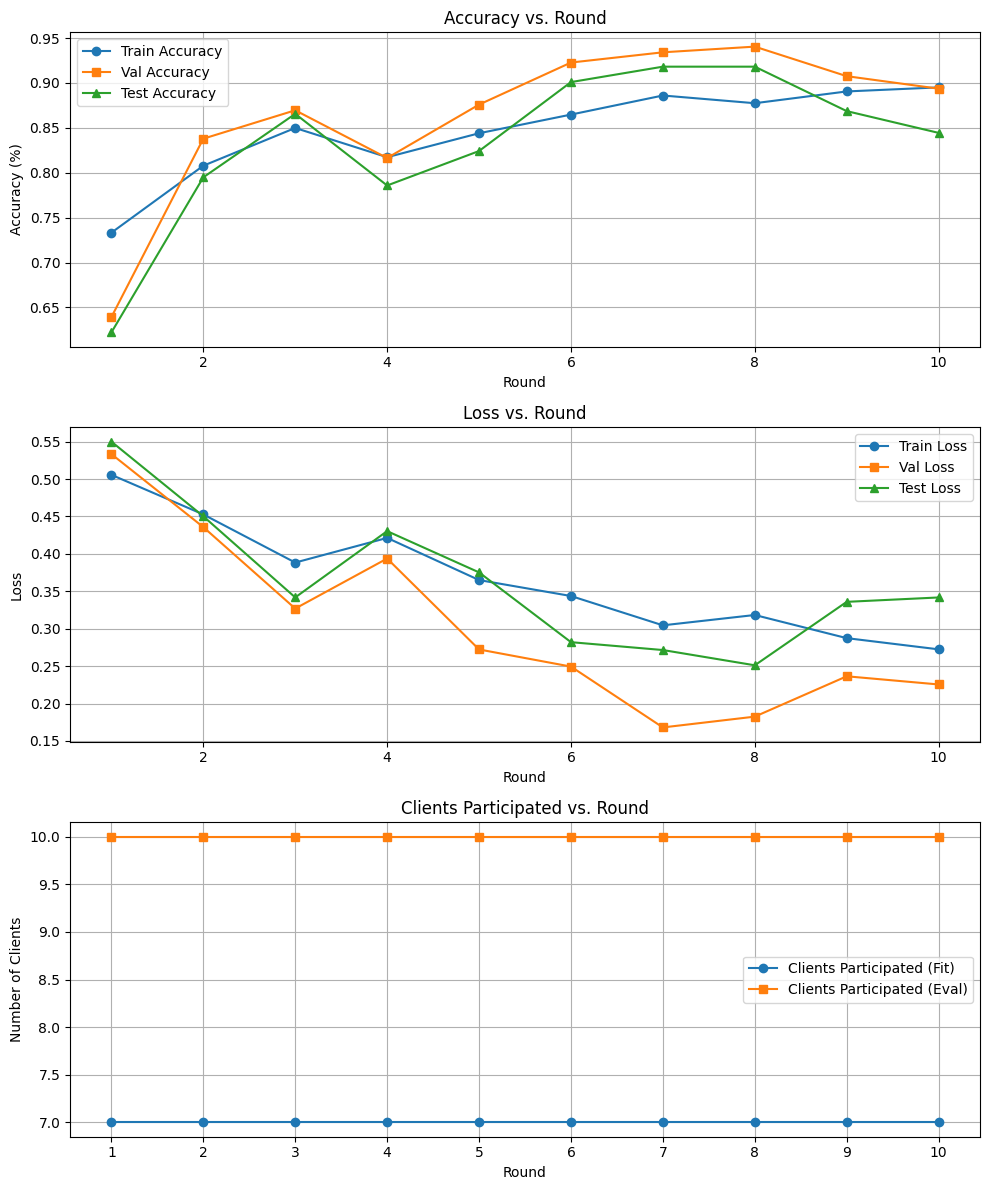

In [ ]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(metrics["train_accuracy"]) + 1), metrics["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(metrics["val_accuracy"]) + 1), metrics["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(metrics["test_accuracy"]) + 1), metrics["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(metrics["train_loss"]) + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(metrics["val_loss"]) + 1), metrics["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(metrics["test_loss"]) + 1), metrics["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(metrics["clients_participated_fit"]) + 1), metrics["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(metrics["clients_participated_eval"]) + 1), metrics["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(metrics["clients_participated_fit"]), len(metrics["clients_participated_eval"])) + 1))

plt.tight_layout()


In [ ]:
def evaluate_final_model(model_class, test_loader, model_path="best_model.pth", device="cuda"):
	# Khởi tạo mô hình
	model = model_class().to(device)
	
	# Load trọng số đã lưu
	model.load_state_dict(torch.load(model_path, map_location=device))
	model.eval()

	criterion = nn.BCEWithLogitsLoss()
	total_loss = 0.0
	correct = 0
	total = 0

	with torch.no_grad():
		progress_bar = tqdm(test_loader, desc="Evaluating Final Model", leave=False)
		for images, labels in progress_bar:
			images = images.to(device)
			labels = labels.to(device).float()
			outputs = model(images)
			loss = criterion(outputs, labels.unsqueeze(1))
			total_loss += loss.item() * labels.size(0)

			predicted = (torch.sigmoid(outputs) > 0.5).float()
			correct += (predicted.squeeze() == labels).sum().item()
			total += labels.size(0)

	avg_loss = total_loss / total if total > 0 else 0.0
	accuracy = correct / total if total > 0 else 0.0
	print(f"\n✅ Final Test Loss: {avg_loss:.4f} | Final Test Accuracy: {accuracy * 100:.2f}%")

	return avg_loss, accuracy

In [ ]:
res = evaluate_final_model(
	BrainMRINet,
	test_loader=load_server_test_datasets(data=testset),
	model_path="/kaggle/working/best_model.pth",
	device=DEVICE
)


✅ Final Test Loss: 0.2208 | Final Test Accuracy: 92.22%
